# **Part 2 -- The citation data**

_Foreword_

The goal of this notebook is to explore and visualize the citation data.

<br>
<font size="6"> 1.1 Dataset: dfcitbasic <br> </font>

Importing the necessary libraries.

In [1]:
import pickle
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from matplotlib.colors import LogNorm, Normalize
from matplotlib.ticker import MaxNLocator
import seaborn as sns
from scipy import stats
import re
import nltk
import missingno as msno
from tqdm import tqdm
import json
import statistics
import math

nltk.download("stopwords", quiet=True)
from nltk.corpus import stopwords
from gensim.models import Phrases
from collections import Counter

# enabling Jupyter Lab to include the output of our plots directly in this notebook
%matplotlib inline


# used to avoid blurry output plots in Jupyter Notebooks
%config InLineBackend.figure_format = "retina"

pd.options.mode.chained_assignment = None

THE DATASET

This dataset is about the citations that we have between the papers of our analysis. This dataset contains:

- ```citing_paper```: the URL link of the internet page of each paper created by OpenAlex. More specifically, this is the paper citing the papers contained in the variable ```cited_paper```.
- ```cited_paper```: the URL link of the internet page the paper cited by the citing paper in ```citing_paper```.
- ```publication_date```: the date of publication of the paper.
- ```year```: the year of publication of the paper.
- ```month```: the year of publication of the paper.

_Sidenote_ 

The variables ```year``` and ```month``` are already added to the dataframe. Even though they directly depend on the variable ```publication_date```, it is meaningful to keep them in the dataset, since this makes the dataset much more manageable for many applications.\
In addition, we will use "cited papers" and "referenced works" as synonyms later in this work. In fact, if a work is referenced, then it has been cited and if it has been cited, necessarily it is in the list of referenced works. For this reason, all the citation analysis is based on the list of referenced works we have for each paper in the database from OpenAlex.

Importing df_full_cleaned, that was cleaned and processed by the file "dataexploration_full_data" and dfcitbasic.

In [2]:
infile_dfcitbasic = open('../creation_data_and_variables/data_creation_variables/dfcitbasic','rb')
dfcitbasic = pickle.load(infile_dfcitbasic)
infile_dfcitbasic.close()

In [3]:
infile_df_full = open('data_exploratory_analysis/df_full_cleaned','rb')
df_full = pickle.load(infile_df_full)
infile_df_full.close()

<div class="alert-info">
1. First visualization of the data
</div>

We visualize the data and some basic info to check that everything is fine.

In [4]:
dfcitbasic

citing_paper                       cited_paper  \
0       https://openalex.org/W2885223756   https://openalex.org/W893234787   
1       https://openalex.org/W2885223756  https://openalex.org/W1559136758   
2       https://openalex.org/W2885223756  https://openalex.org/W2290426788   
3       https://openalex.org/W2885223756  https://openalex.org/W3021222613   
4       https://openalex.org/W2755079943  https://openalex.org/W1993203618   
...                                  ...                               ...   
986870  https://openalex.org/W2794757751  https://openalex.org/W1279320161   
986871  https://openalex.org/W2794757751  https://openalex.org/W2487288527   
986872  https://openalex.org/W2794757751  https://openalex.org/W2504579840   
986873  https://openalex.org/W4214588288  https://openalex.org/W1944092705   
986874  https://openalex.org/W4214588288  https://openalex.org/W2055603434   

       publication_date     month  year  
0            2018-08-16    August  2018  
1            2018-08-16    August  2018  
2            2018-08-16    August  2018  
3            2018-08-16    August  2018  
4            2017-10-01   October  2017  
...                 ...       ...   ...  
986870       2017-11-01  November  2017  
986871       2017-11-01  November  2017  
986872       2017-11-01  November  2017  
986873       2021-10-01   October  2021  
986874       2021-10-01   October  2021  

[986875 rows x 5 columns]

In [5]:
dfcitbasic.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 986875 entries, 0 to 986874
Data columns (total 5 columns):
 #   Column            Non-Null Count   Dtype 
---  ------            --------------   ----- 
 0   citing_paper      986875 non-null  object
 1   cited_paper       986875 non-null  object
 2   publication_date  986875 non-null  object
 3   month             986875 non-null  object
 4   year              986875 non-null  int64 
dtypes: int64(1), object(4)
memory usage: 37.6+ MB


Nothing special to say, everything is just as expected.

<div class="alert-info">
2. Consideration of the types of the variables
</div>

In [6]:
dfcitbasic.dtypes

citing_paper        object
cited_paper         object
publication_date    object
month               object
year                 int64
dtype: object

The types are the ones I expected, this is good. Years are integers here and not strings, this is something I will have to keep in mind later if I want to select data based on the year value.

<div class="alert-info">
3. Unique values in my dataset
</div>

In [7]:
unique_values = dfcitbasic.select_dtypes(include=["object",'int64']).nunique()
unique_values

citing_paper        135448
cited_paper         103024
publication_date      6669
month                   12
year                    21
dtype: int64

__Observation__

Just as expected there are more citing papers than cited papers. In fact, every paper cites other papers, but not every paper is necessarily cited itself. There are a lot of different publication date, but this not very surprising either.

<div class="alert-info">
4. Visualizing possible duplicates in my database
</div>

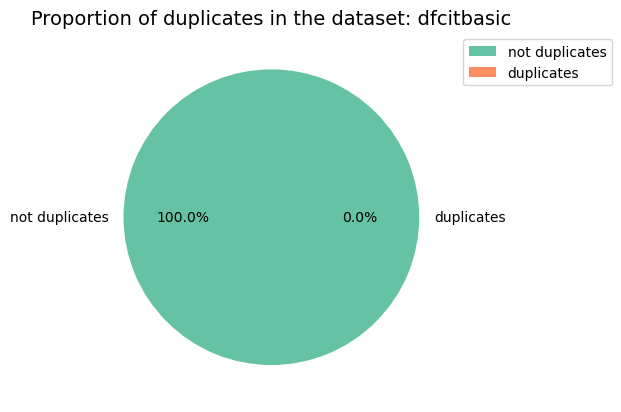

In [8]:
# little fancy visualization for dfcitbasic

dfcitbasic_noduplicates = dfcitbasic.drop_duplicates()

# data to be displayed
data = [len(dfcitbasic_noduplicates), len(dfcitbasic) - len(dfcitbasic_noduplicates)]

# labels for radability and intepretation
labels = ["not duplicates", "duplicates"]

# colors
colors = sns.color_palette("Set2")

# creating the pie chart
plt.pie(data, labels=labels, colors=colors, autopct="%0.1f%%")

# title
plt.title(
    "Proportion of duplicates in the dataset: dfcitbasic",
    color="black",  # I am using the 'white' color here, as I am using the 'dark mode' of Jupyter Lab.
    fontsize=14,
)

# legend
plt.legend(bbox_to_anchor=(1, 1))

# calling the pie chart
plt.show()

__Observations__

No duplicates in my data. This was expected, since I created this database on purpose without duplicates.

<div class="alert-info">
5. Visualization of missing values.
</div>

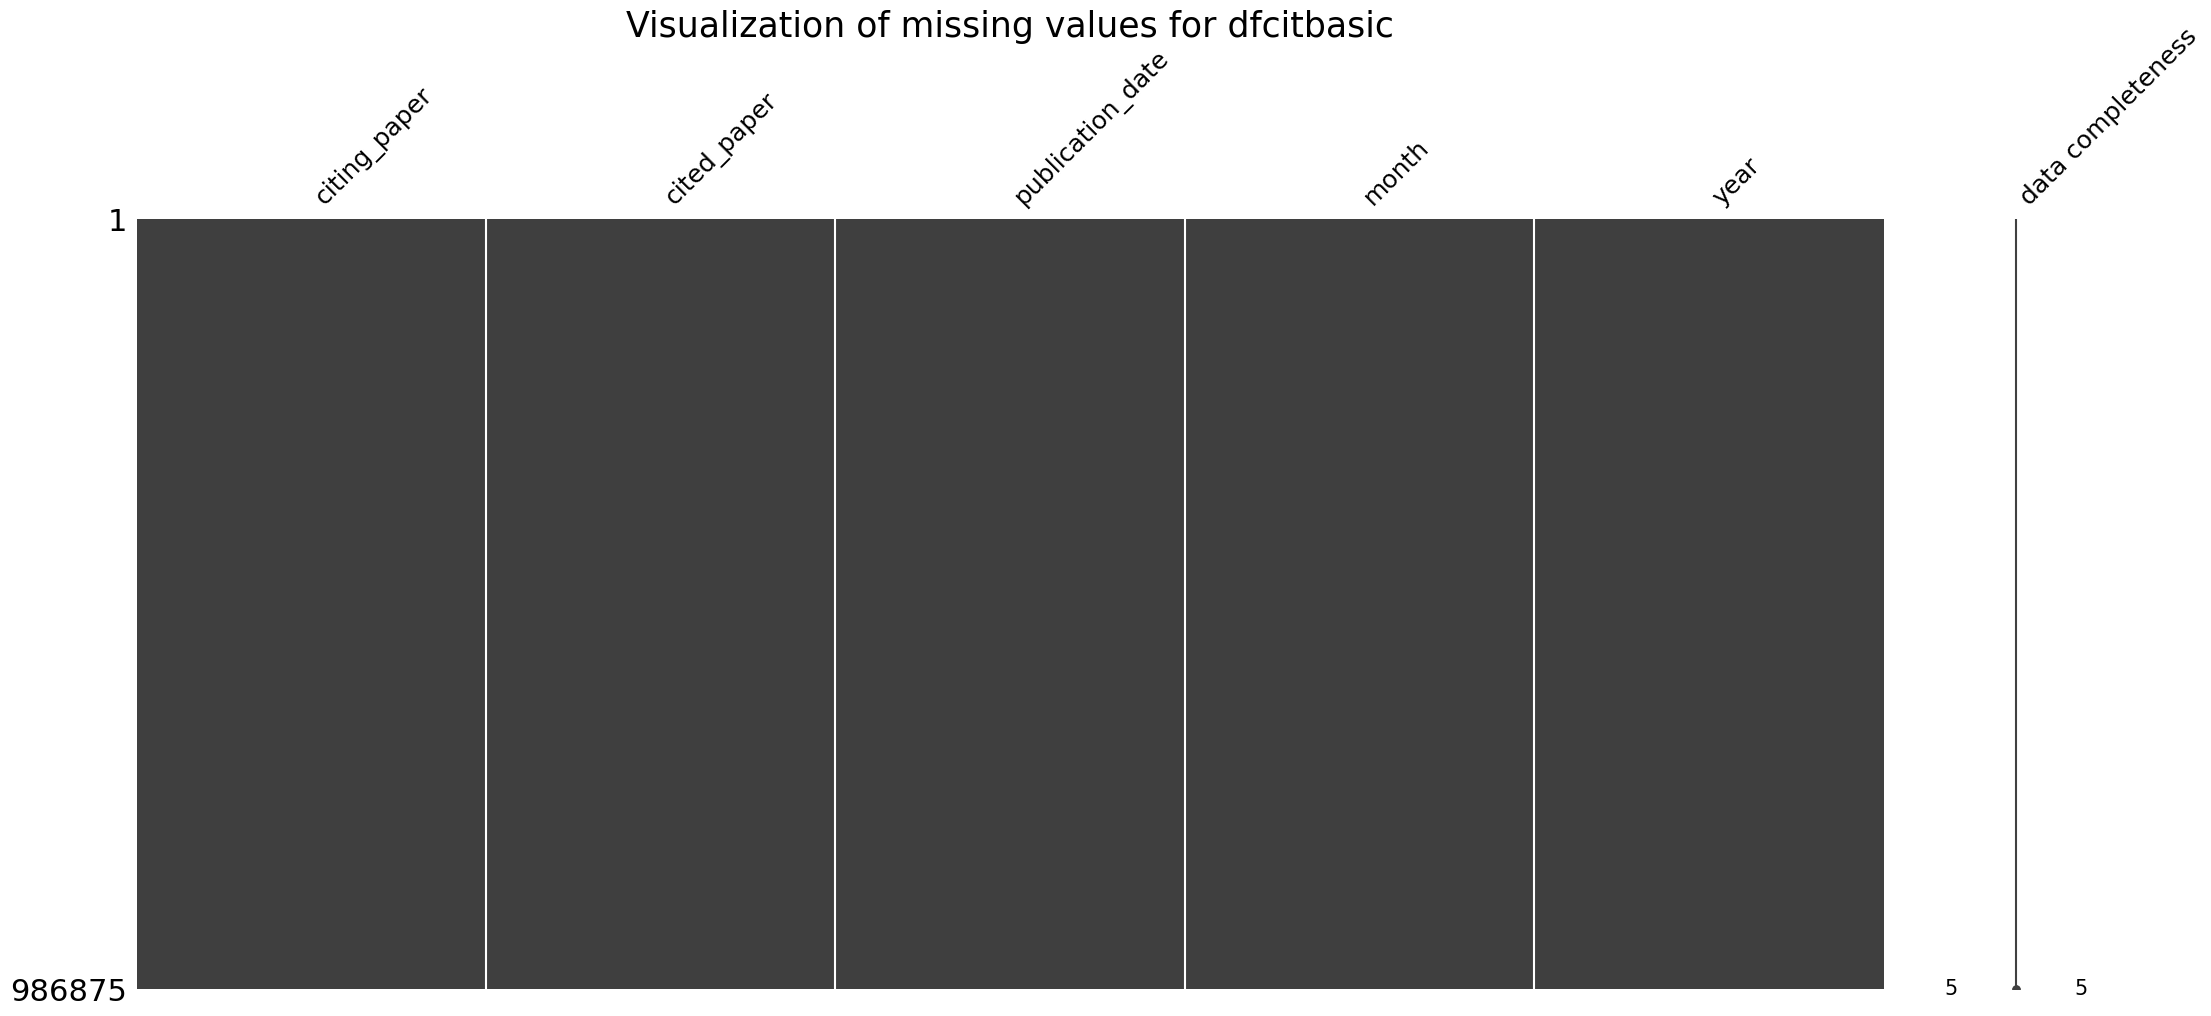

In [9]:
msno.matrix(dfcitbasic,labels=True, fontsize=18)
plt.title("Visualization of missing values for dfcitbasic",fontsize = 25)
plt.show()

__Observations__

As expected there are no missing values in ```cited_paper```, since we eliminated all the papers with no referenced works. We have a full database with no missing values, which is what we aimed at.

<div class="alert-info">
6. In depth visualization of the data and basic statistics
</div>

__Visualization of the distribution of citations by month over all the years__

We now visualize, how many citations there are by month, considering all the years from 2002 to 2022 together.

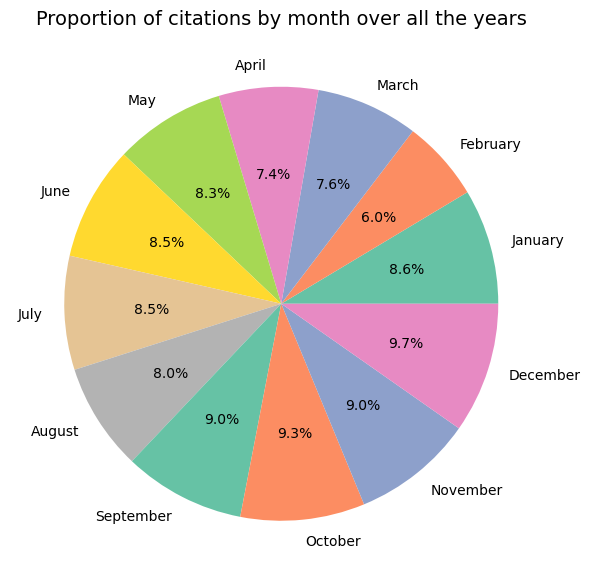

In [10]:
# little fancy visualization of the proportion of citations by month over all the years
my_months = ['January','February','March','April','May','June','July','August','September','October','November','December']

data = []

for month in my_months:
    # we compute the number of cited papers (therefore of citations) overall all months together
    infosmonth = dfcitbasic.loc[dfcitbasic['month'] == month].copy()
    infosmonth=infosmonth[~infosmonth['cited_paper'].isnull()].copy()
    data.append(len(infosmonth))

# labels for readability and intepretation
labels = ['January','February','March','April','May','June','July','August','September','October','November','December']


# colors
colors = sns.color_palette("Set2")


f = plt.figure()
f.set_figwidth(7)
f.set_figheight(9)
# creating the pie chart
plt.pie(data, labels=labels, colors=colors, autopct="%0.1f%%")


# title
plt.title(
    "Proportion of citations by month over all the years",
    color="black",  # I am using the 'white' color here, as I am using the 'dark mode' of Jupyter Lab.
    fontsize=14,
)


# calling the pie chart
plt.show()

__Observations__

The citations are distributed almost uniformly over time. This is due to the fact, that we cleaned our original dataset and redistributed the excess of data in January uniformly over the whole year. Nevertheless, there is a slight increase of the citations number from the beginning of the year to the end of the year. It finishes with almost 10 % in December which a lot compared to the beginning of the year.

__Progression of the total of citations over time__

Now, I visualize the progression of the total of citations over time.

First, I consider the numbers of cited papers.

In [11]:
dfcitbasic.cited_paper.tolist()
len(list(set(dfcitbasic.cited_paper.tolist())))

103024

Then, I visualize the progression of the total of citations over time.

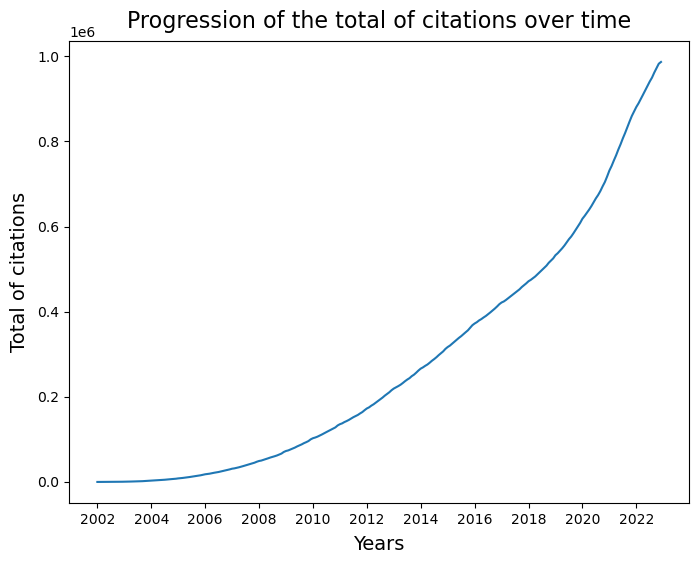

In [12]:
# lables and title specs
label_specs = {"fontsize": 14,"labelpad":6}
title_specs = {"fontsize": 16, "y": 1.01}

my_years = [2002,2003,2004,2005,2006,2007,2008,2009,2010,2011,2012,2013,2014,2015,2016,2017,2018,2019,2020,2021,2022]
my_months = ['January','February','March','April','May','June','July',
            'August','September','October','November','December']
my_years_label = [2002,2004,2006,2008,2010,2012,2014,2016,2018,2020,2022]

x_cor = np.arange(0,252,24) 

total_cit_tothemonth = []

totalnumbercit= 0
for year in my_years:
    infosyear = dfcitbasic.loc[dfcitbasic['year'] == year].copy()
    for month in my_months:
        # again we compute the number of cited papers to obtain the number of citations.
        infosmonth = infosyear.loc[infosyear['month'] == month].copy()
        infosmonth=infosmonth[~infosmonth['cited_paper'].isnull()].copy()
        totalnumbercit = totalnumbercit+ len(infosmonth)
        total_cit_tothemonth.append(totalnumbercit)
        

#plt.scatter(np.arange(0,132),total_cit_tothemonth)
f = plt.figure()
f.set_figwidth(8)
f.set_figheight(6)

plt.plot(total_cit_tothemonth)

plt.title('Progression of the total of citations over time',**title_specs)
plt.xlabel('Years',**label_specs)
plt.ylabel('Total of citations',**label_specs)

plt.xticks(x_cor,my_years_label)

plt.show()

__Observations__

We see a smooth exponential progression of the total number of citations over time. There are always more citations in total and the number of citations increases exponentially over time. At the end of 2022 there is a little decrease, but this is just due to the fact, that we do not have all the data yet. The exponential increase of the total number of citations over time can show two things: first the number of papers increases and second the interconnectivitiy between the different technologies increases.
To distinguish these two cases, we will now visualize the evolution of the ratio total number of citations / total number of papers published so far, to see if there really is an increase of the interconnectivity or if the exponential increase of the total number of citations is just due to the the increase of quantity of published papers.

We select only the information we are interested in.

In [13]:
df_time = df_full[['title','month','year']]
df_time = df_time.drop_duplicates()

We now visualize the evolution of the ratio total number of citations / total number of papers published so far.

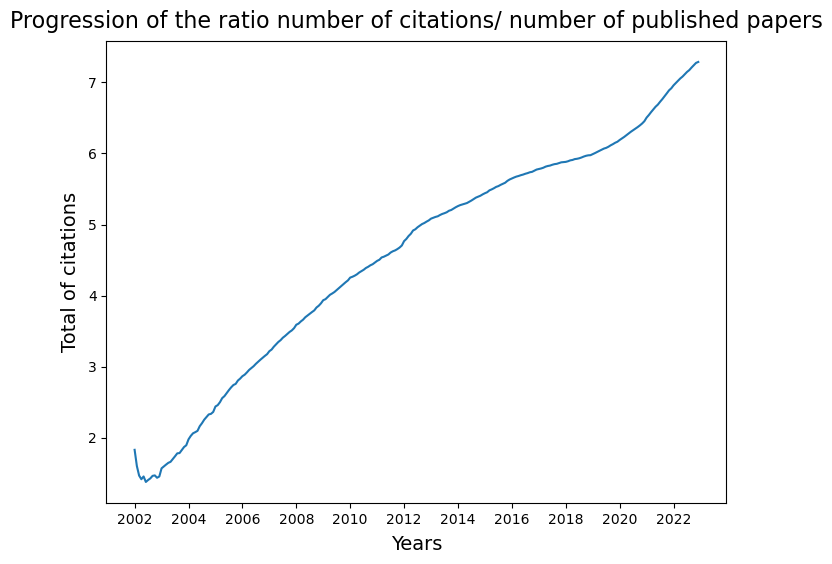

In [14]:
# lables and title specs
label_specs = {"fontsize": 14,"labelpad":6}
title_specs = {"fontsize": 16, "y": 1.01}

my_years = [2002,2003,2004,2005,2006,2007,2008,2009,2010,2011,2012,2013,2014,2015,2016,2017,2018,2019,2020,2021,2022]
my_months = ['January','February','March','April','May','June','July',
            'August','September','October','November','December']
my_years_label = [2002,2004,2006,2008,2010,2012,2014,2016,2018,2020,2022]

x_cor = np.arange(0,252,24) 

ratio_citpaper_tothemonth = []


totalnumbercit= 0
totalnumberpaper= 0
for year in my_years:
    infosyear = dfcitbasic.loc[dfcitbasic['year'] == year].copy()
    full_year = df_time[df_time['year']==year].copy()
    for month in my_months:
        infosmonth = infosyear.loc[infosyear['month'] == month].copy()
        infosmonth=infosmonth[~infosmonth['cited_paper'].isnull()].copy()
        full_month = full_year[full_year['month']==month].copy()
        totalnumberpaper=totalnumberpaper+len(full_month)
        
        totalnumbercit = totalnumbercit+ len(infosmonth)
        
        ratio_citpaper_tothemonth.append(totalnumbercit/totalnumberpaper)
        

        

#plt.scatter(np.arange(0,252),total_cit_tothemonth)
f = plt.figure()
f.set_figwidth(8)
f.set_figheight(6)

plt.plot(ratio_citpaper_tothemonth)

plt.title('Progression of the ratio number of citations/ number of published papers',**title_specs)
plt.xlabel('Years',**label_specs)
plt.ylabel('Total of citations',**label_specs)

plt.xticks(x_cor,my_years_label)

plt.show()

__Observations__

We see that there is a visible increase of the number of citation divided by the number of papers. We must keep in mind, that at the beginning this ratio is very low, because of the fact, that we consider only the referenced works that belong to our period of time. For this reason, the papers published in 2002-2003 have almost no referenced works according to our criteria. This is why at the beginning the number of citations is very low, but the number of published papers is also very low. Then we have a sudden decrease, due to the fact, that the number of published papers increases while the number of citations does not increase very much. After a while the ratio becomes more stable and starts to increase in a more stable way. In fact, the increase of the ratio is quite clear and keeps increasing even at the end of our period of analysis. For this reason, we can claim, that there is indeed an increase of the interconnectivity over time in the field of encryption technologies.

We now create two lists, one with the number of times each cited paper was cited and one with the number of times each citing paper cited. They will be useful to visualize many informations later.

In [15]:
numbertimes_eachpaper_iscited = []
numbertimes_eachpaper_isciting = []

# not to take the rows with NaN cited paper.
dfcitbasic_nonan=dfcitbasic[~dfcitbasic['cited_paper'].isnull()].copy()

# Give the list as static input and store it in a variable.
list_cited_paper = dfcitbasic_nonan.cited_paper.tolist()
list_citing_paper = dfcitbasic_nonan.citing_paper.tolist()


# Calculate the frequency of all the given list elements using the Counter()
# function which returns the element and its frequency as key-value pair
# and store this dictionary in a variable(say freqncyDictionary)
freqncyDictionary_citedpaper = Counter(list_cited_paper)
freqncyDictionary_citingpaper = Counter(list_citing_paper)

        
numbertimes_eachpaper_iscited=list(freqncyDictionary_citedpaper.values())        
numbertimes_eachpaper_isciting=list(freqncyDictionary_citingpaper.values())         


with open('data_exploratory_analysis/numbertimes_eachpaper_iscited', 'wb') as f:
    pickle.dump(numbertimes_eachpaper_iscited, f)
    
with open('data_exploratory_analysis/numbertimes_eachpaper_isciting', 'wb') as f:
    pickle.dump(numbertimes_eachpaper_isciting, f)    

In [16]:
print('The number of papers citing is :'+str(len(list(set(list_citing_paper)))))

The number of papers citing is :135448


In [17]:
print('The number of papers in df_full_cleaned is:'+str(len(list(set(df_full.paper.tolist())))))

The number of papers in df_full_cleaned is:135448


In [18]:
print('The number of cited papers is :'+str(len(list(set(list_cited_paper)))))

The number of cited papers is :103024


__Observations__

As expected, the number of papers is equal to the number of citing papers, since we selected only the papers to which we have referenced works associated. There are less cited papers, because several papers from our set of papers were simply not cited.

In [19]:
infile_list1 = open('data_exploratory_analysis/numbertimes_eachpaper_iscited','rb')
numbertimes_eachpaper_iscited = pickle.load(infile_list1)
infile_list1.close()

infile_list2 = open('data_exploratory_analysis/numbertimes_eachpaper_isciting','rb')
numbertimes_eachpaper_isciting = pickle.load(infile_list2)
infile_list2.close()

In [20]:
print('We first consider how many times each paper is cited and some basic statistics about it:')
print(' ')
print('The minimum of citations for a paper is 0')
print('The maximum of citations for a paper is '+str(max(numbertimes_eachpaper_iscited)))
print('The average of citations for a cited paper is '+str(sum(numbertimes_eachpaper_iscited)/len(list(set(df_full.paper.tolist())))))
print(' ')
print(' ')

print('We then consider how many times each paper cites another paper and some basic statistics about it:')
print(' ')
print('The minimal amount of citations of a paper is '+str(min(numbertimes_eachpaper_isciting)))
print('The maximal amount of citations of a paper is '+str(max(numbertimes_eachpaper_isciting)))
print('The average amount of citations for a citing paper is '+str(sum(numbertimes_eachpaper_isciting)/len(numbertimes_eachpaper_isciting)))

We first consider how many times each paper is cited and some basic statistics about it:
 
The minimum of citations for a paper is 0
The maximum of citations for a paper is 2338
The average of citations for a cited paper is 7.286006437894986
 
 
We then consider how many times each paper cites another paper and some basic statistics about it:
 
The minimal amount of citations of a paper is 1
The maximal amount of citations of a paper is 491
The average amount of citations for a citing paper is 7.286006437894986


__Distribution of citing papers with respect to citations__

We want to understand how the papers are distributed with respect to the number of papers they cite over the period 2002-2022.

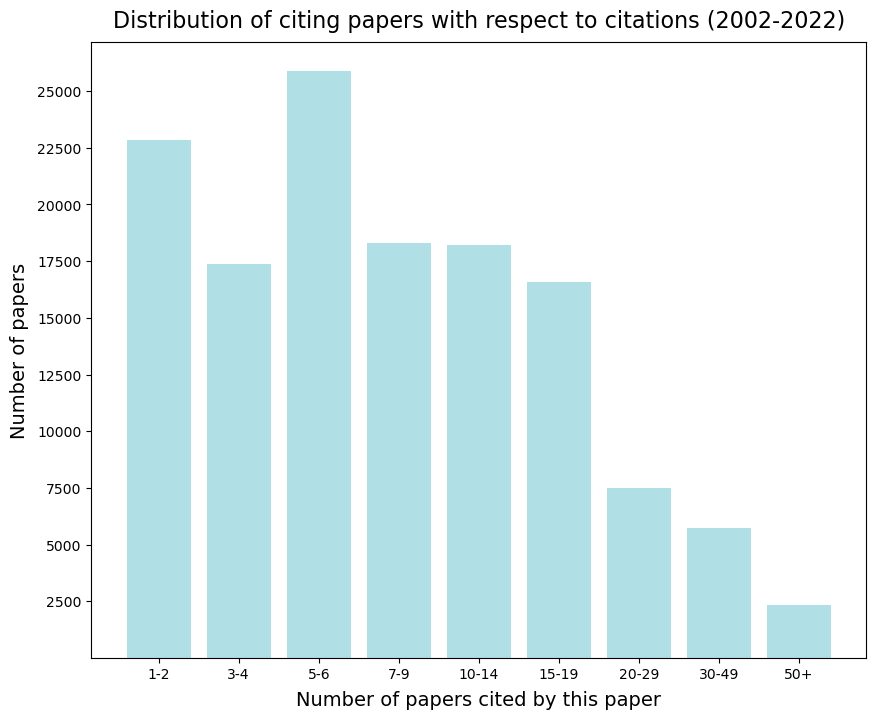

In [21]:
label_specs = {"fontsize": 14,"labelpad":6}
title_specs = {"fontsize": 16, "y": 1.01}

# little fancy visualization for df_hindices
my_months = ['January','February','March','April','May','June','July','August','September','October','November','December']

data = []

steps_sorting= [0,1,2,3,5,7,10,15,20,30,50,100000]

x_label= ['1-2','3-4','5-6','7-9','10-14','15-19','20-29','30-49','50+']

numberpapers= []

for i in range(1,10):
    above = steps_sorting[i+1]
    below =steps_sorting[i]
    specificlist=[x for x in numbertimes_eachpaper_isciting if above>x>=below]
    numberpapers.append(len(specificlist))

f = plt.figure()
f.set_figwidth(10)
f.set_figheight(8)

# score bar chat
# setting the axes of our horizontal bar plot


plt.bar(x_label, numberpapers, color="powderblue")  
# setting the column of our dataset ('number of papers') that we want to plot as a numerical variable


# setting the labels of our axes
plt.xlabel("Number of papers cited by this paper",**label_specs)
plt.ylabel("Number of papers",**label_specs)

y_cor = [2500,5000,7500,10000,12500,15000,17500,20000,22500,25000]
label = [str(x) for x in y_cor]
plt.yticks(y_cor,label)


# to see something, because, without that we do not see anything!

# setting the bar plot title
plt.title(
    "Distribution of citing papers with respect to citations (2002-2022)",**title_specs
)

# showing the bar plot (command not necessary, but it avoids to print the explanation text)
plt.show()

__Observation__

We see that most of the citing papers have less than 10 referenced works. This is due to the fact, that I filtered the list of referenced works and included only the ones related to the concepts of encryption technologies we are studying and that were published in the period 2002-2022. For this reason many papers from 2002 to 2005 approximately have only few referenced papers in my database because they cited many papers published before 2002.

Of course, as said before, the papers we consider in the citations are only the papers related to our group of technologies. These papers might have cited papers related to other technologies, but this is not what we are considering in these studies.

Note that when '1-2' is written, this means that I consider the interval including 1 and 2.

__Distribution of cited papers with respect to citations__

We want to understand how the papers are distributed with respect to the number papers that cite them over the period 2012-2022. 

_Sidenote_


The number of papers that are not cited does not depend on the papers with missing information about their referenced works. Rather it is computed as the number of citing papers minus the number of cited papers. Of course, this is not perfect, but it already gives a certain idea.

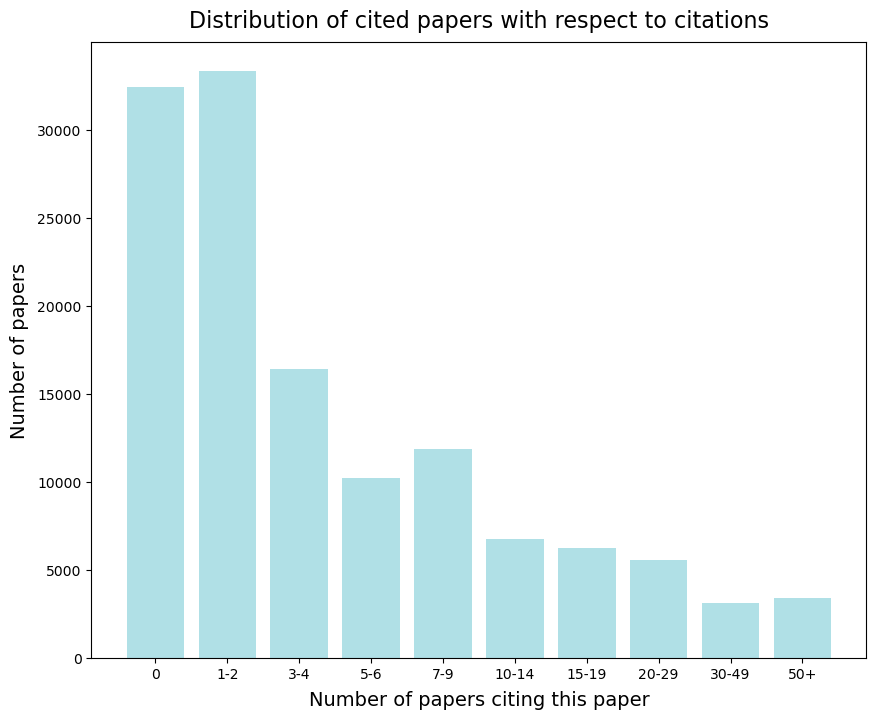

In [22]:
label_specs = {"fontsize": 14,"labelpad":6}
title_specs = {"fontsize": 16, "y": 1.01}

# little fancy visualization for df_hindices
my_months = ['January','February','March','April','May','June','July','August','September','October','November','December']

data = []

#we take only the information about papers which were cited
dfcitbasic_nonan=dfcitbasic[~dfcitbasic['cited_paper'].isnull()].copy()

# Give the list as static input and store it in a variable.
list_cited_paper = list(set(dfcitbasic_nonan.cited_paper.tolist()))
list_citing_paper = list(set(dfcitbasic_nonan.citing_paper.tolist()))

numbercitingpaper_notcited=len(list_citing_paper)-len(list_cited_paper)

steps_sorting= [0,1,2,3,5,7,10,15,20,30,50,100000]

x_label= ['0','1-2','3-4','5-6','7-9','10-14','15-19','20-29','30-49','50+']

numberpapers= [numbercitingpaper_notcited]

for i in range(9):
    above = steps_sorting[i+1]
    below =steps_sorting[i]
    specificlist=[x for x in numbertimes_eachpaper_iscited if above>=x>below]
    numberpapers.append(len(specificlist))

f = plt.figure()
f.set_figwidth(10)
f.set_figheight(8)

# score bar chat
# setting the axes of our horizontal bar plot

plt.bar(x_label, numberpapers, color="powderblue")  
# setting the column of our dataset ('number of papers') that we want to plot as a numerical variable

# setting the labels of our axes
plt.xlabel("Number of papers citing this paper",**label_specs)
plt.ylabel("Number of papers",**label_specs)

#y_cor = [2500,5000,7500,10000,12500,15000,17500,20000,22500,25000]
#label = [str(x) for x in y_cor]
#plt.yticks(y_cor,label)

# to see something, because, without that we do not see anything!

# setting the bar plot title
plt.title("Distribution of cited papers with respect to citations",**title_specs)

# showing the bar plot (command not necessary, but it avoids to print the explanation text)
plt.show()

__Observations__

The distribution of the number of papers citing each paper is quite similar to the distribution of the number of papers cited by each paper. Nevertheless, there are slightly less cited papers than citing papers, therefore we see that many papers are not cited or are cited only 1 to 2 times.

__Final remark__

Overall the dataset citbasic seems to be completely fine, and ready to be used. The citations are well distributed over the time period and many insights can be generated using this dataframe.

<br>
<font size="6"> 1.2 Dataset: dfcitations <br> </font>

THE DATASET

The dataset was created using the dataset dfcitbasic. The dataset contains several information about the number of citations of each paper over time.

- ```paper```: the ID used for each paper used by OpenAlex
- ```year```: the year we are considering for the citations
- ```month```: the month we are considering for the citations
- ```cituptothistime_year```: the number of citations the paper received from January 2002 to the end of December of the year we are considering.
- ```cituptothistime_month```: the number of citations the paper received from January 2002 to the the month in the year we are considering.
- ```citforthemonth```: the number of citations the paper received for this month during this specific year.
- ```citfortheyear```: the number of citations the paper received for the given year.

_Sidenote_

The variables above are computed for each year and month from 2002 to 2022. These variables are also computed for the months and the years before the publication date. In this case they are simply zero of course. For this reason, this dataset is full of zeros.

In [23]:
infile_finaldicocitation = open('../creation_data_and_variables/data_creation_variables/finaldicocitation','rb')
dfcitations = pickle.load(infile_finaldicocitation)
infile_finaldicocitation.close()

<div class="alert-info">
1. Display a few entries from the DataFrame and basic information
</div>

In [24]:
dfcitations

paper  year      month  \
0         https://openalex.org/W2885223756  2002    January   
1         https://openalex.org/W2885223756  2002   February   
2         https://openalex.org/W2885223756  2002      March   
3         https://openalex.org/W2885223756  2002      April   
4         https://openalex.org/W2885223756  2002        May   
...                                    ...   ...        ...   
34132891  https://openalex.org/W4214588288  2022     August   
34132892  https://openalex.org/W4214588288  2022  September   
34132893  https://openalex.org/W4214588288  2022    October   
34132894  https://openalex.org/W4214588288  2022   November   
34132895  https://openalex.org/W4214588288  2022   December   

          cituptothistime_year  cituptothistime_month  citforthemonth  \
0                            0                      0               0   
1                            0                      0               0   
2                            0                      0               0   
3                            0                      0               0   
4                            0                      0               0   
...                        ...                    ...             ...   
34132891                     0                      0               0   
34132892                     0                      0               0   
34132893                     0                      0               0   
34132894                     0                      0               0   
34132895                     0                      0               0   

          citfortheyear  
0                     0  
1                     0  
2                     0  
3                     0  
4                     0  
...                 ...  
34132891              0  
34132892              0  
34132893              0  
34132894              0  
34132895              0  

[34132896 rows x 7 columns]

In [25]:
dfcitations.describe()

year  cituptothistime_year  cituptothistime_month  \
count  3.413290e+07          3.413290e+07           3.413290e+07   
mean   2.012000e+03          1.772468e+00           1.632147e+00   
std    6.055301e+00          1.422879e+01           1.352490e+01   
min    2.002000e+03          0.000000e+00           0.000000e+00   
25%    2.007000e+03          0.000000e+00           0.000000e+00   
50%    2.012000e+03          0.000000e+00           0.000000e+00   
75%    2.017000e+03          0.000000e+00           0.000000e+00   
max    2.022000e+03          2.338000e+03           2.338000e+03   

       citforthemonth  citfortheyear  
count    3.413290e+07   3.413290e+07  
mean     2.415019e-02   2.898023e-01  
std      2.541713e-01   2.266286e+00  
min      0.000000e+00   0.000000e+00  
25%      0.000000e+00   0.000000e+00  
50%      0.000000e+00   0.000000e+00  
75%      0.000000e+00   0.000000e+00  
max      7.200000e+01   3.550000e+02

In [26]:
dfcitations.head()

paper  year     month  cituptothistime_year  \
0  https://openalex.org/W2885223756  2002   January                     0   
1  https://openalex.org/W2885223756  2002  February                     0   
2  https://openalex.org/W2885223756  2002     March                     0   
3  https://openalex.org/W2885223756  2002     April                     0   
4  https://openalex.org/W2885223756  2002       May                     0   

   cituptothistime_month  citforthemonth  citfortheyear  
0                      0               0              0  
1                      0               0              0  
2                      0               0              0  
3                      0               0              0  
4                      0               0              0

<div class="alert-info">
2. We check the data type for each column.
</div>

In [27]:
dfcitations.dtypes

paper                    object
year                      int64
month                    object
cituptothistime_year      int64
cituptothistime_month     int64
citforthemonth            int64
citfortheyear             int64
dtype: object

The types of variables are exactly the ones expected.

<div class="alert-info">
3. Visualization of the proportion of duplicates in my dataset
</div>

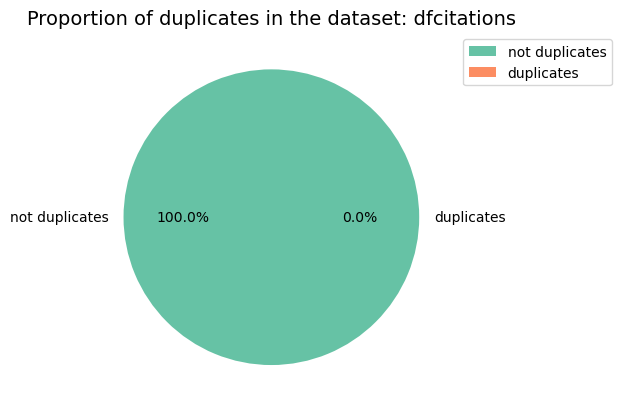

In [28]:
# little fancy visualization for dfcitations

dfcitations_noduplicates = dfcitations.drop_duplicates()

# data to be displayed
data = [len(dfcitations_noduplicates), len(dfcitations) - len(dfcitations_noduplicates)]

# labels for radability and intepretation
labels = ["not duplicates", "duplicates"]

# colors
colors = sns.color_palette("Set2")

# creating the pie chart
plt.pie(data, labels=labels, colors=colors, autopct="%0.1f%%")

# title
plt.title(
    "Proportion of duplicates in the dataset: dfcitations",
    color="black",  # I am using the 'white' color here, as I am using the 'dark mode' of Jupyter Lab.
    fontsize=14,
)

# legend
plt.legend(bbox_to_anchor=(1, 1))

# calling the pie chart
plt.show()

In [29]:
len(list(set(dfcitations.paper.tolist())))

135448

__Observations__

As expected there are no duplicates in my dataset and we have exactly the number of papers we wanted, so everything is fine.

<div class="alert-info">
4. Analysis of the unique values of the dataset
</div>

In [30]:
unique_values = dfcitations.select_dtypes(include=["object",'int64']).nunique()
unique_values

paper                    135448
year                         21
month                        12
cituptothistime_year        760
cituptothistime_month      1472
citforthemonth               50
citfortheyear               197
dtype: int64

The unique values are the ones we expected, for this reason, everything is fine.

<div class="alert-info">
5. Visualization of the proportion of missing values in the data
</div>

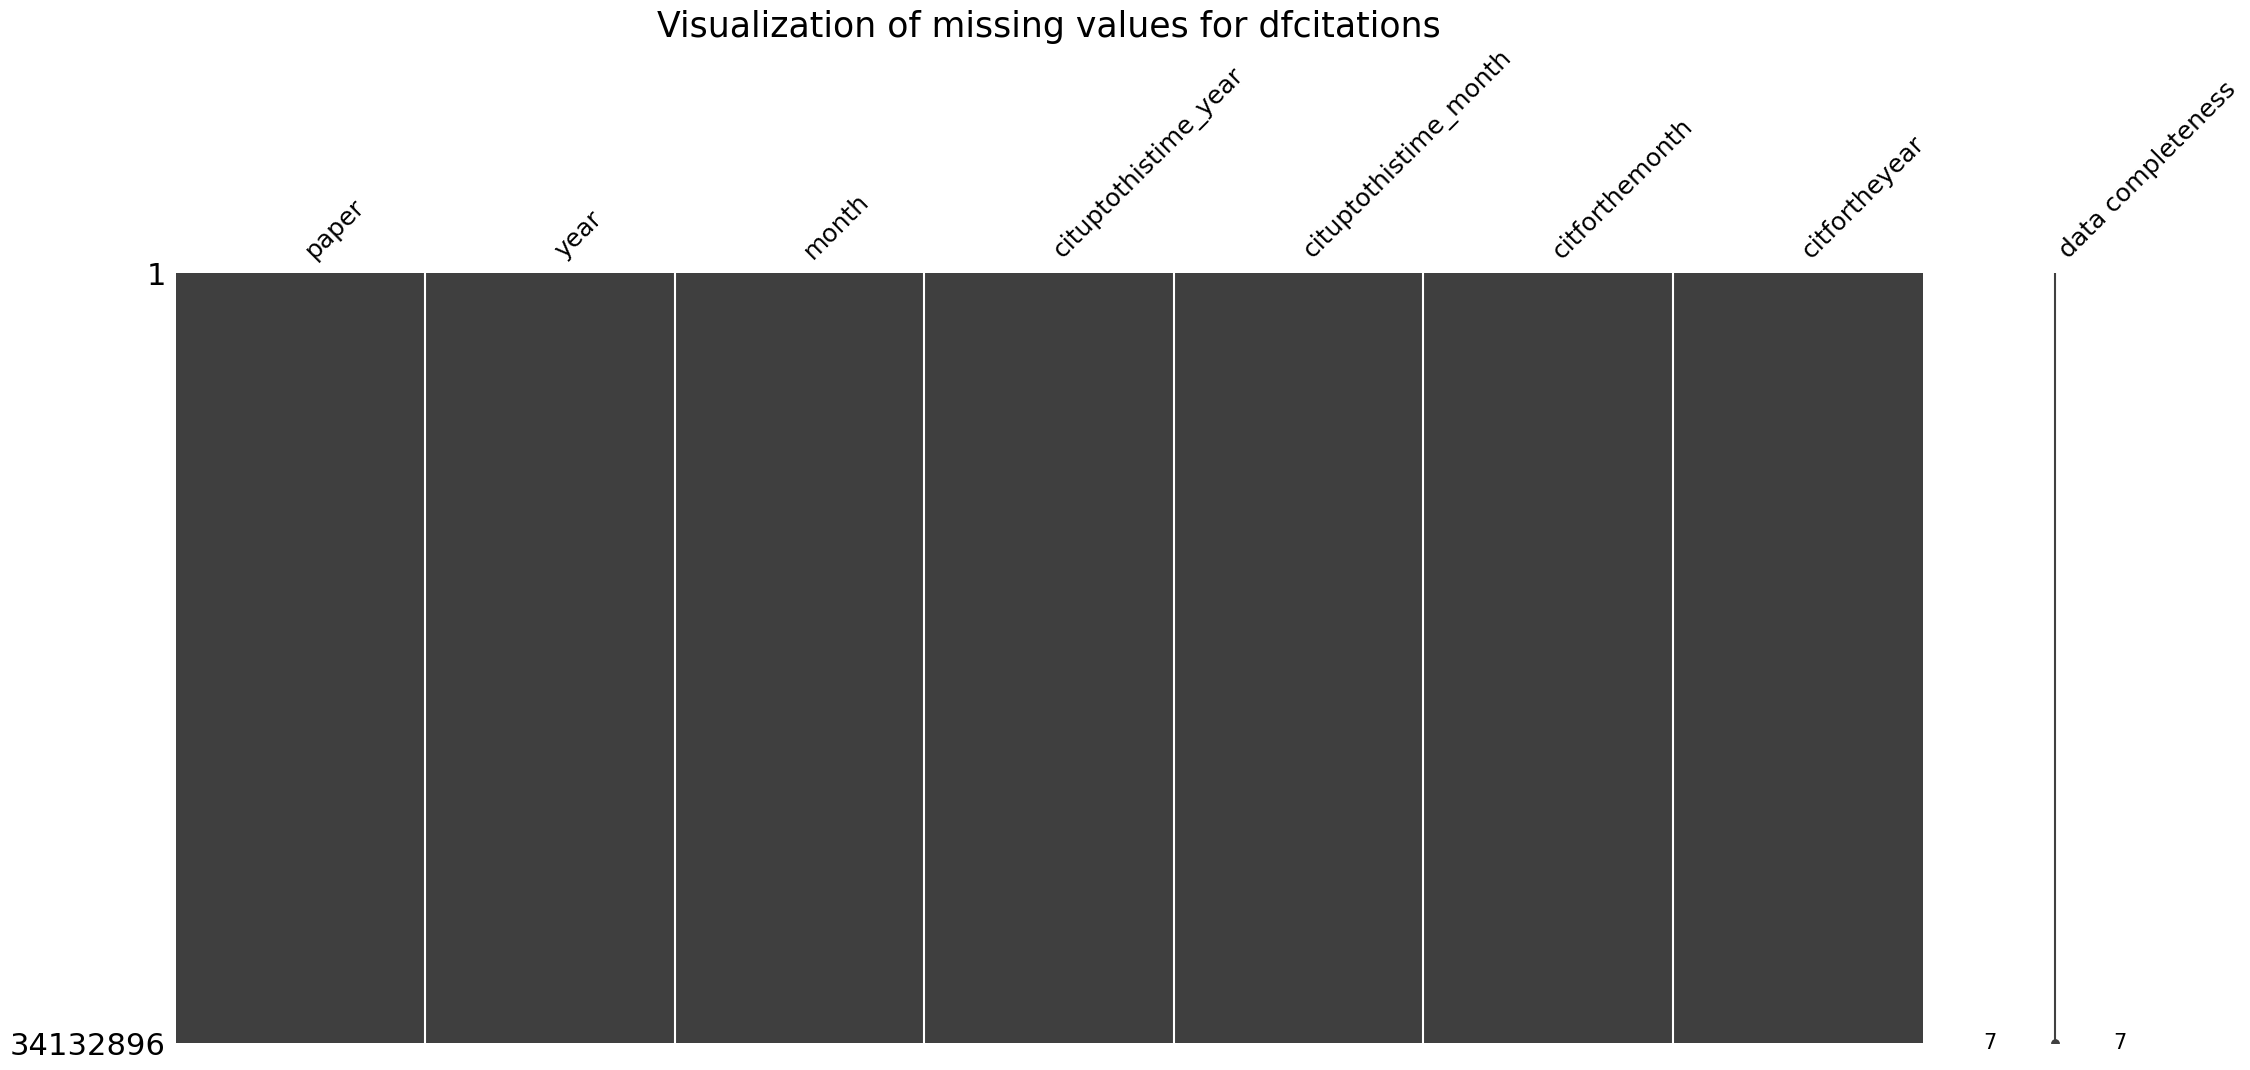

In [31]:
msno.matrix(dfcitations,labels=True, fontsize=18)
plt.title("Visualization of missing values for dfcitations",fontsize = 25)
plt.show()

__Observations__

As planned there are no missing values in this dataset. In fact, this is how I created this dataset.

<div class="alert-info">
6. Visualization and statistics about the dataset
</div>

We now visualize a bar chart with the total number of citations by year over all the papers related to encryption technologies.

In [32]:
dfcitations.dtypes

paper                    object
year                      int64
month                    object
cituptothistime_year      int64
cituptothistime_month     int64
citforthemonth            int64
citfortheyear             int64
dtype: object

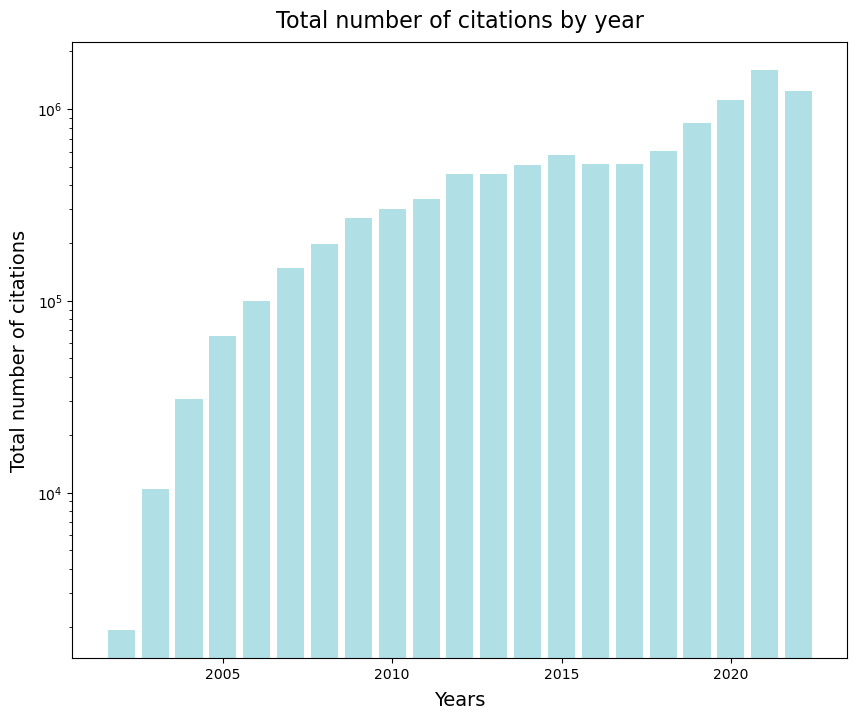

In [33]:
# lables and title specs
label_specs = {"fontsize": 14,"labelpad":6}
title_specs = {"fontsize": 16, "y": 1.01}

my_years = [2002,2003,2004,2005,2006,2007,2008,2009,2010,2011,2012,2013,2014,2015,2016,2017,2018,2019,2020,2021,2022]


x_cor = np.arange(0,252,24) 

total_citations_byyear = []

for year in my_years:
    newdf = dfcitations.loc[dfcitations['year']==year].copy()
    myinfos = newdf.citfortheyear.tolist()
    total_citations_byyear.append(sum(myinfos))
# creating the figure and setting its size

f = plt.figure()
f.set_figwidth(10)
f.set_figheight(8)

# score bar chat
# setting the axes of our horizontal bar plot

plt.bar(my_years, total_citations_byyear, color="powderblue")  
# setting the column of our dataset ('number of papers') 
# that we want to plot as a numerical variable

# setting the labels of our axes
plt.xlabel("Years",**label_specs)
plt.ylabel("Total number of citations",**label_specs)
plt.yscale('log')



# setting the bar plot title
plt.title("Total number of citations by year",**title_specs)

# showing the bar plot (command not necessary, but it avoids to print the explanation text)
plt.show()

__Observations__

We see that there are more and more people citing each other. The field of encryption technologies is more and more interconnected and there are always more people working in it.
Nonetheless, during the early years of our time period, papers might cite papers, which were published before the time period of this study. So it is important to keep this in mind. There is an increase of the general interconnectivity of the field, which slightly biased since there already is an increase of publication in the field.

__Total number of papers by year in the field of encryption technologies__

The plot chart below shows how many papers are produced by year in the field of encryption technologies. We see that the amount of published papers increases and is correlated with amount of increase of citations.

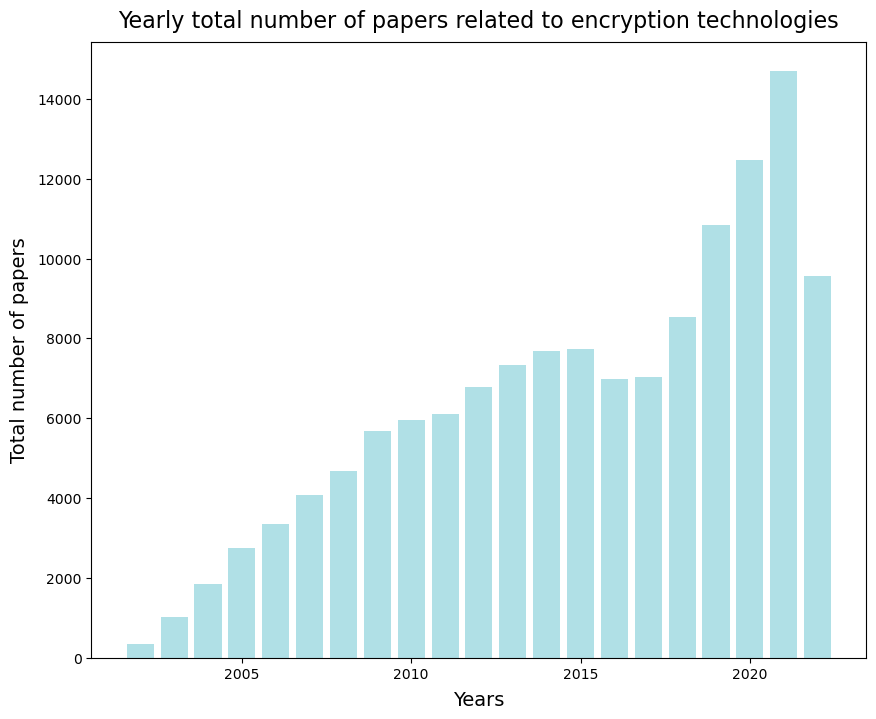

In [34]:
label_specs = {"fontsize": 14,"labelpad":6}
title_specs = {"fontsize": 16, "y": 1.01}

my_years = [2002,2003,2004,2005,2006,2007,2008,2009,2010,2011,2012,2013,2014,2015,2016,2017,2018,2019,2020,2021,2022]

total_papers_byyear = []

for year in my_years:
    selectionforperiod = df_time[df_time['year']==year]
    numberpapers = len(selectionforperiod)
    total_papers_byyear.append(numberpapers)

# creating the figure and setting its size

f = plt.figure()
f.set_figwidth(10)
f.set_figheight(8)

# score bar chat
# setting the axes of our horizontal bar plot

plt.bar(my_years, total_papers_byyear, color="powderblue")  
# setting the column of our dataset ('number of papers') that we want to plot as a numerical variable

# setting the labels of our axes
plt.xlabel("Years",**label_specs)
plt.ylabel("Total number of papers",**label_specs)


# setting the bar plot title
plt.title("Yearly total number of papers related to encryption technologies",**title_specs)

# showing the bar plot (command not necessary, but it avoids to print the explanation text)
plt.show()

__Observations__

There is a visible progression of the number of papers produced every year. We started with an average number of 200 papers per year and now we are rather at 15000. The field is growing fast, and faster than citations. This quite understandable, since the citations come later, once the papers were published. First there is a lot of publications and then a lot of citations.

__Comparison between the number of citations and of publications by year__

For each year, we visualize a bar chart containing the number of citations and the number of published papers for each month.

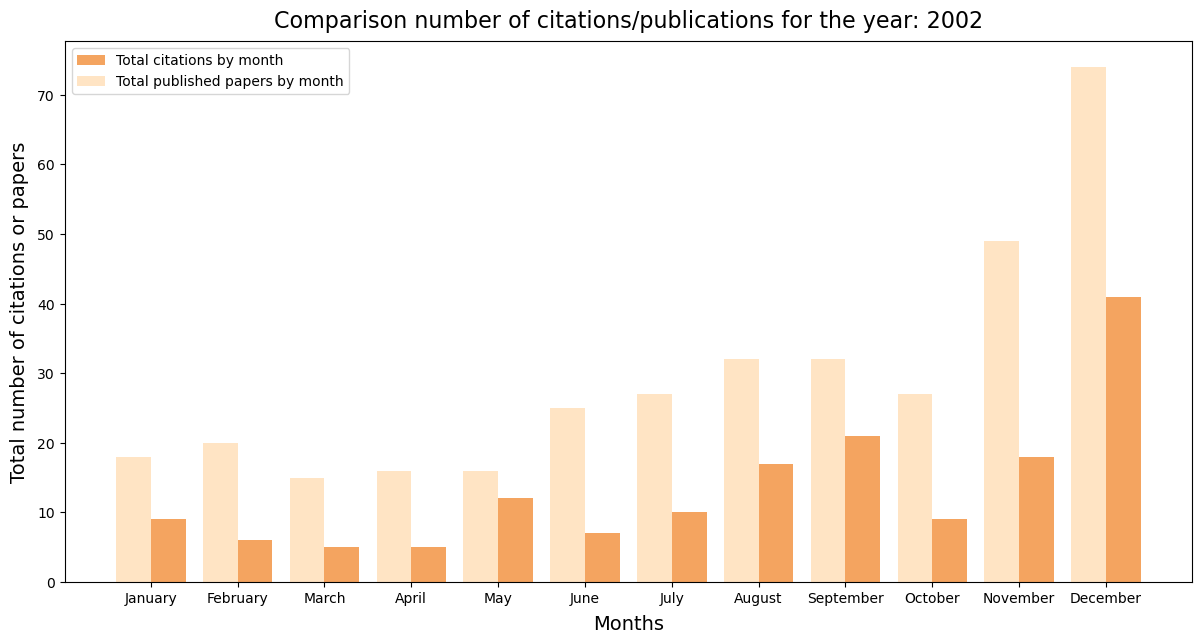

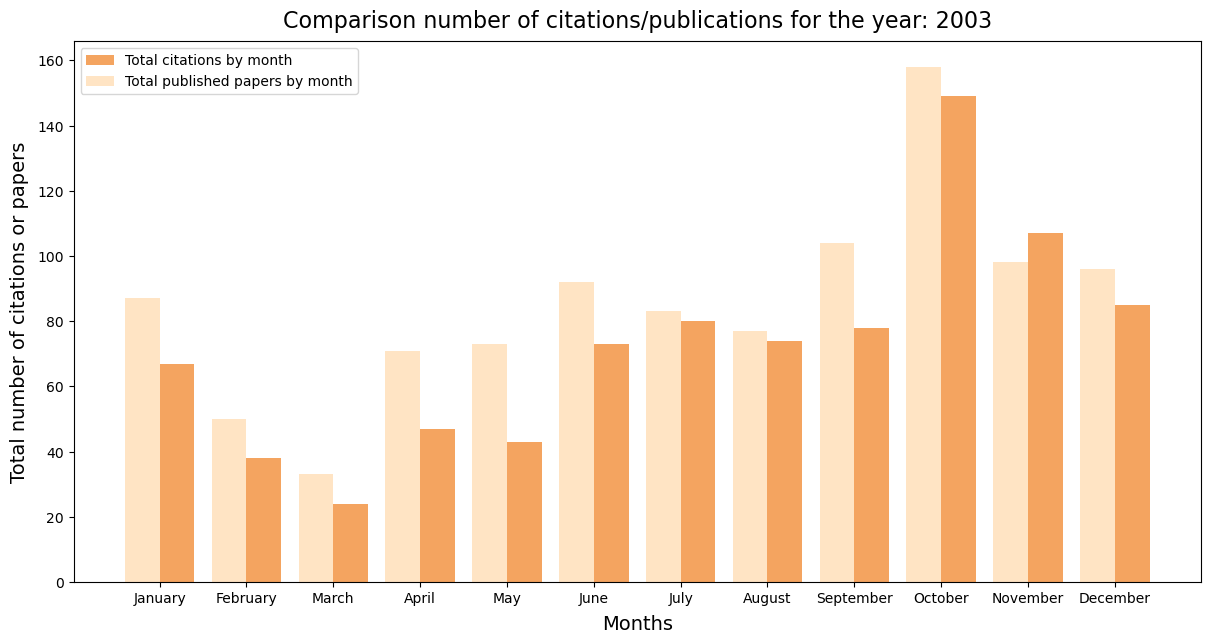

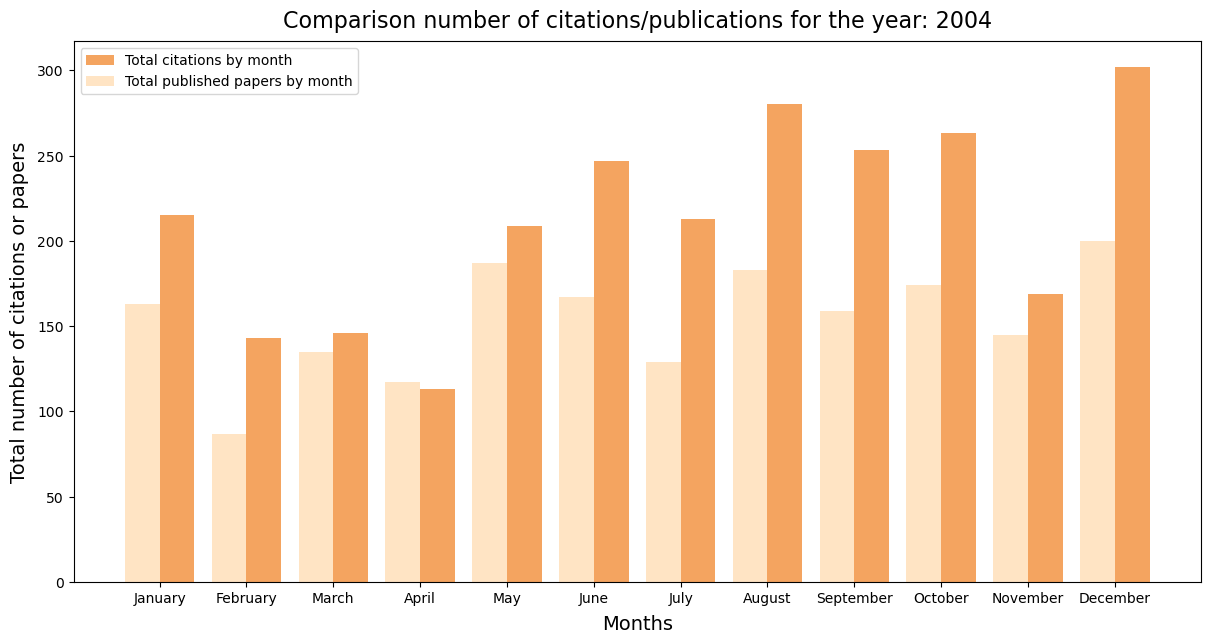

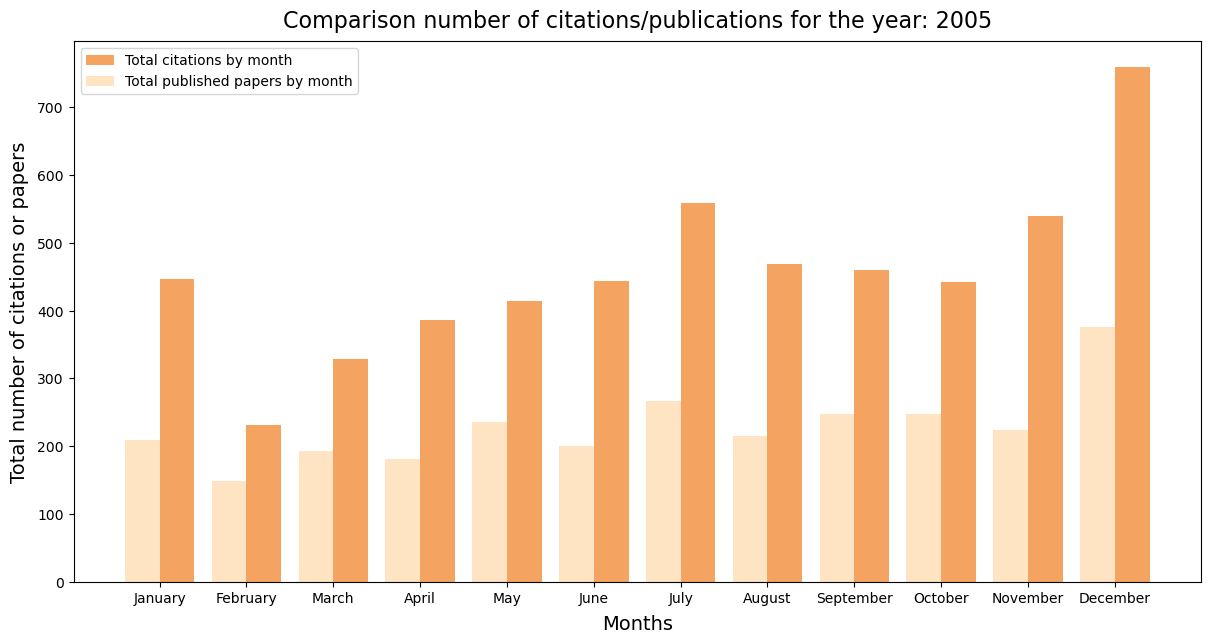

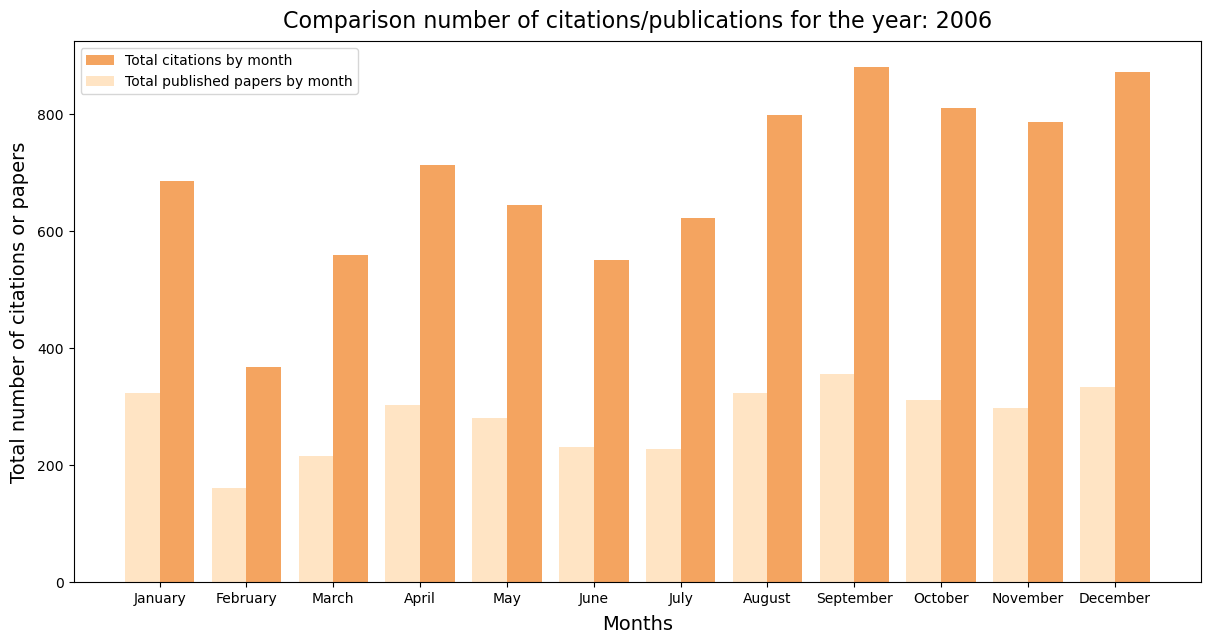

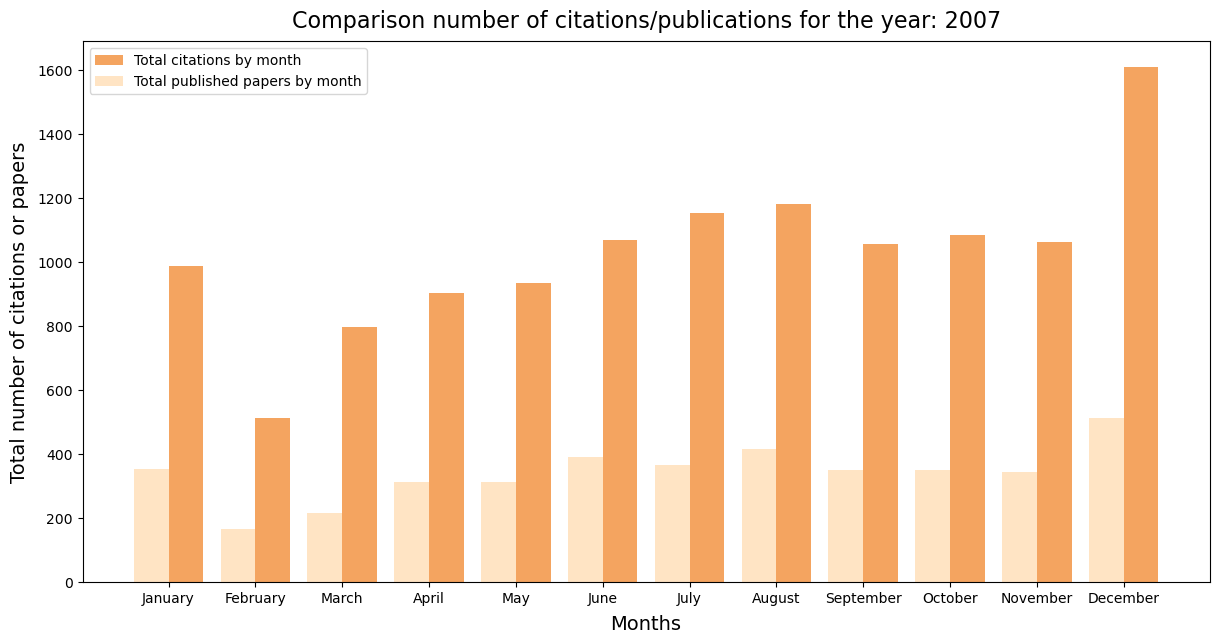

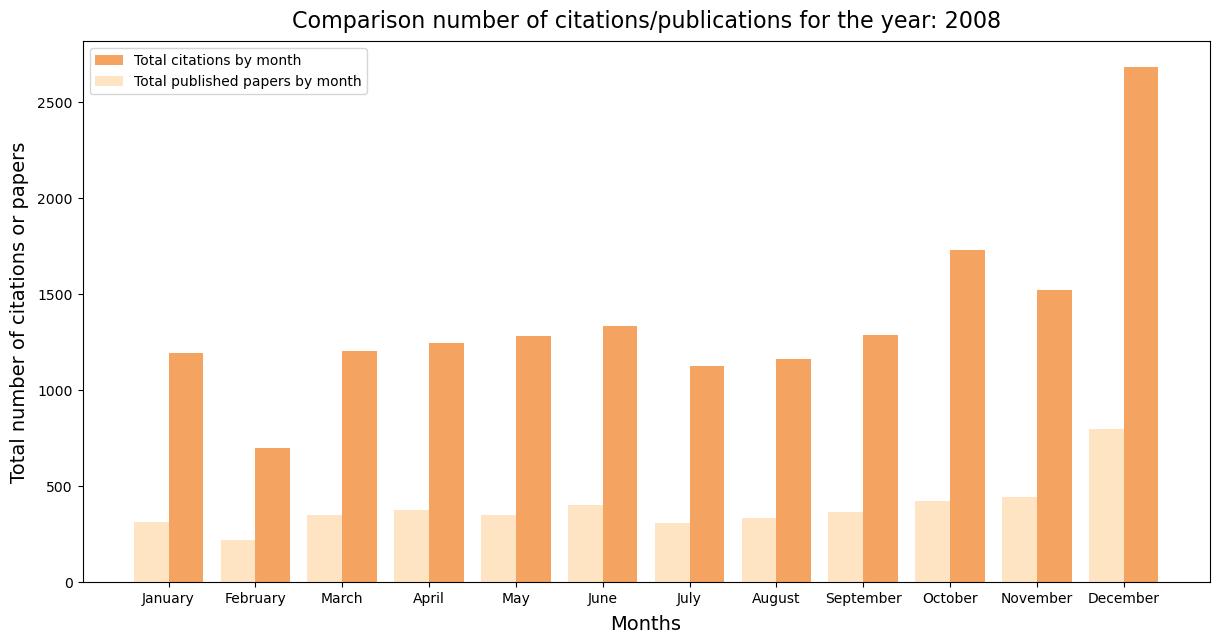

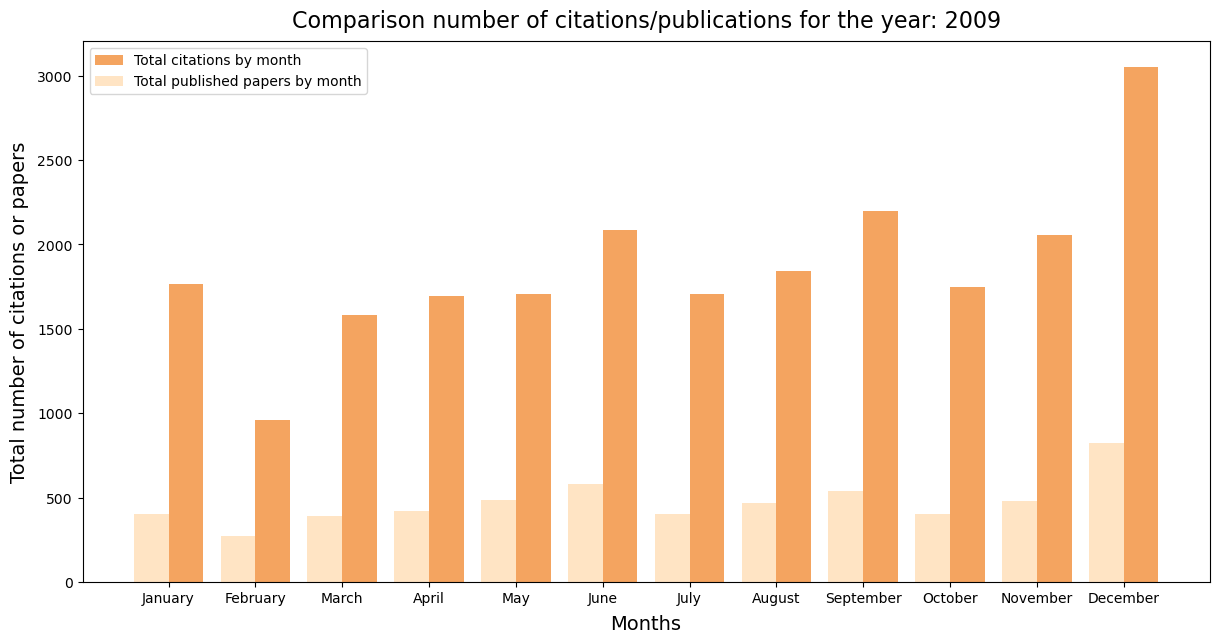

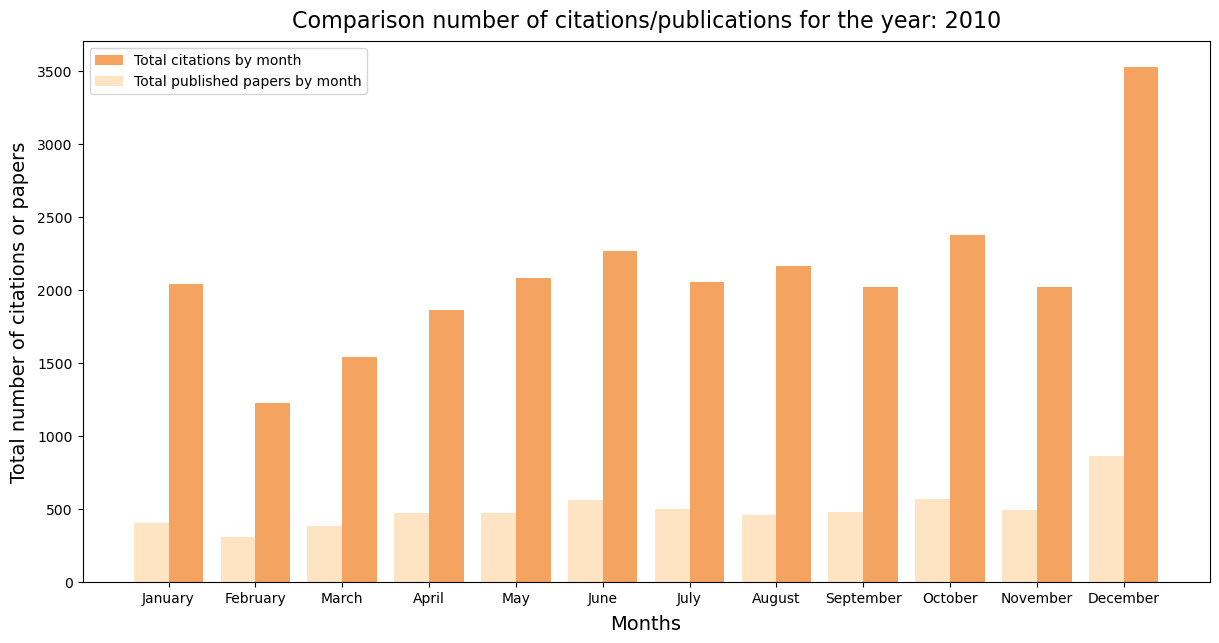

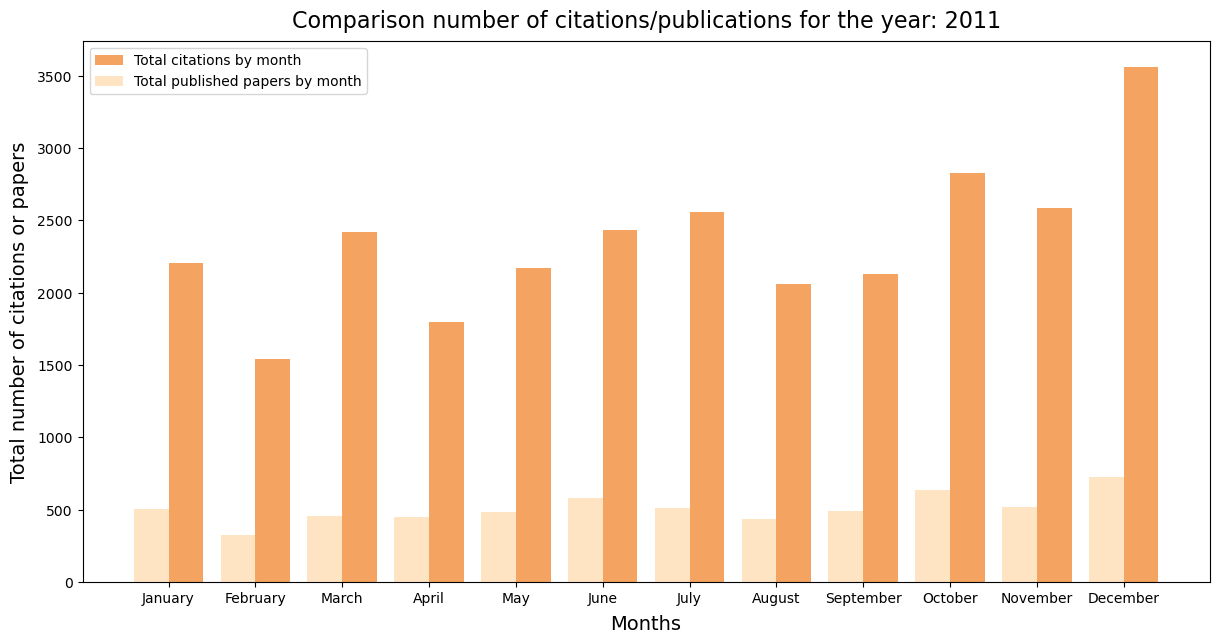

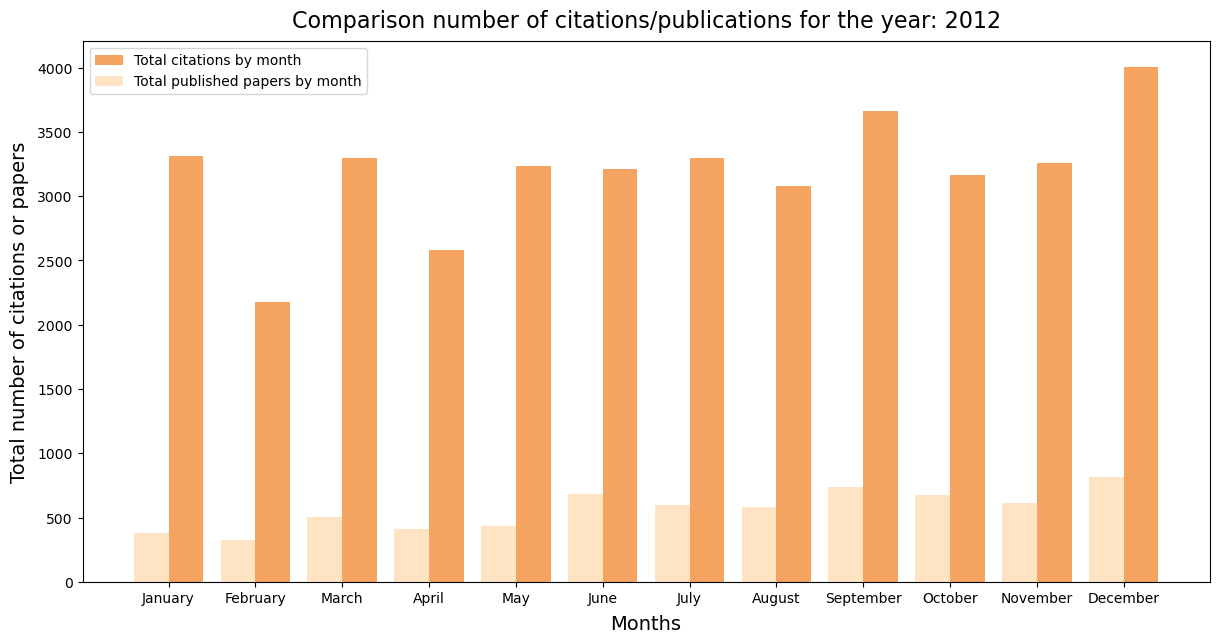

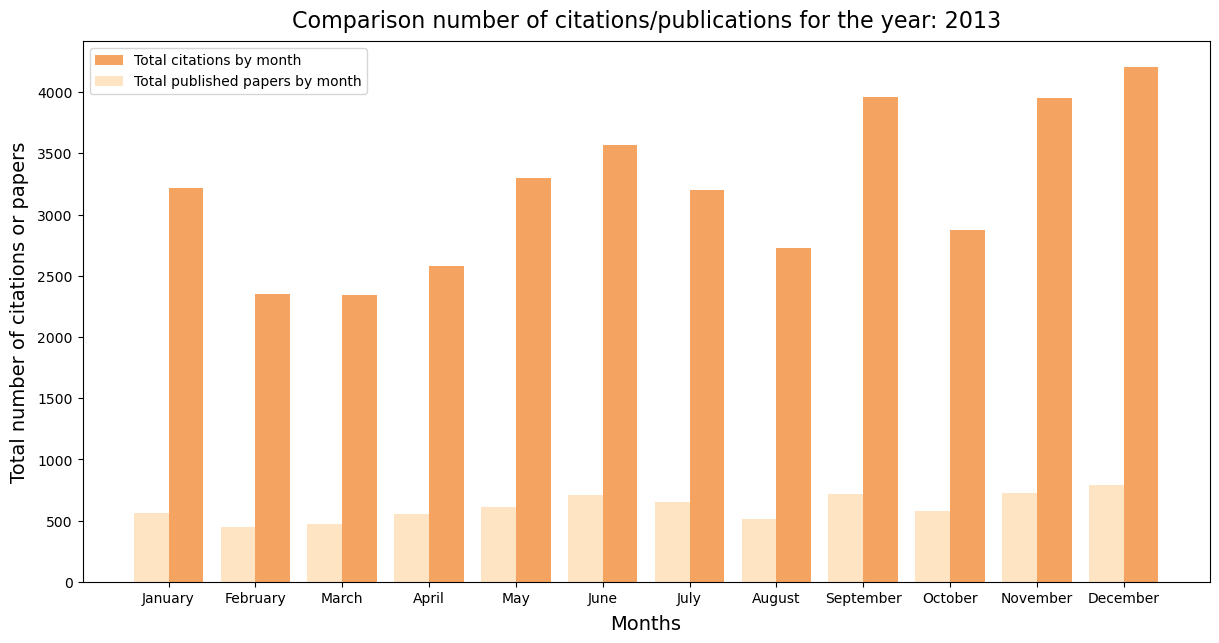

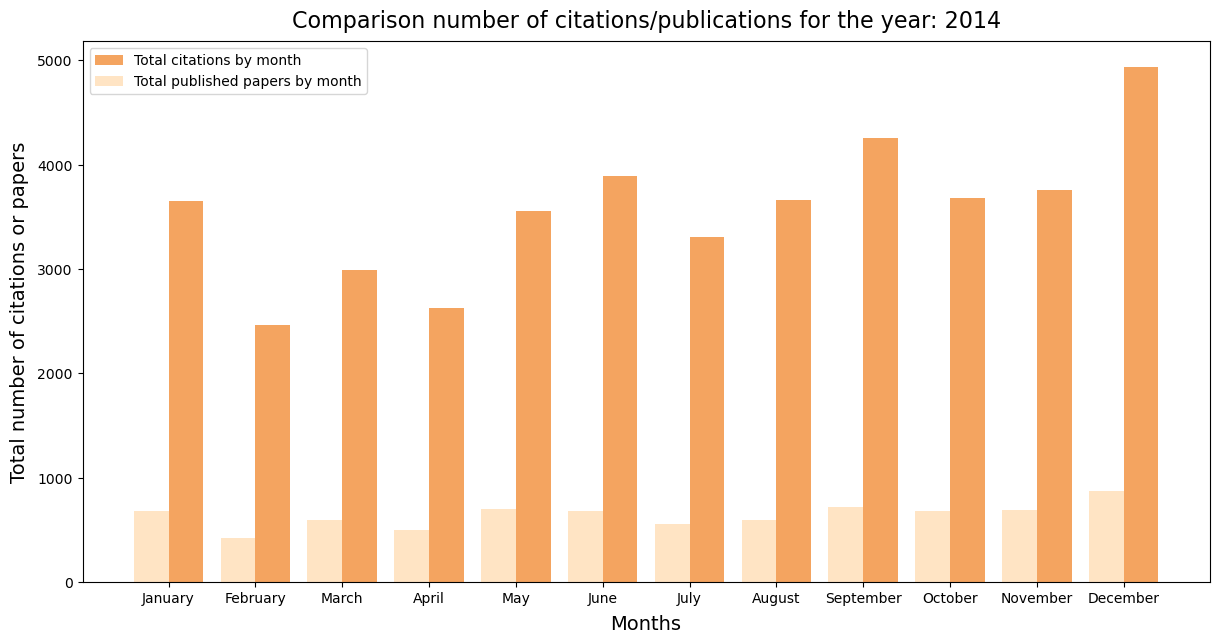

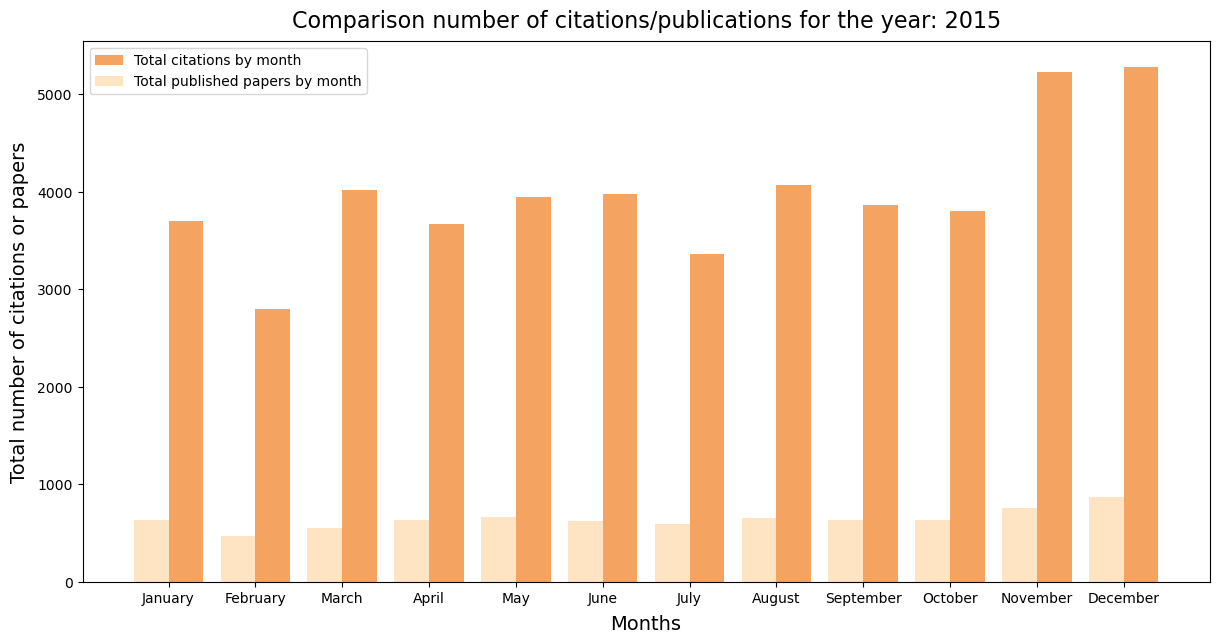

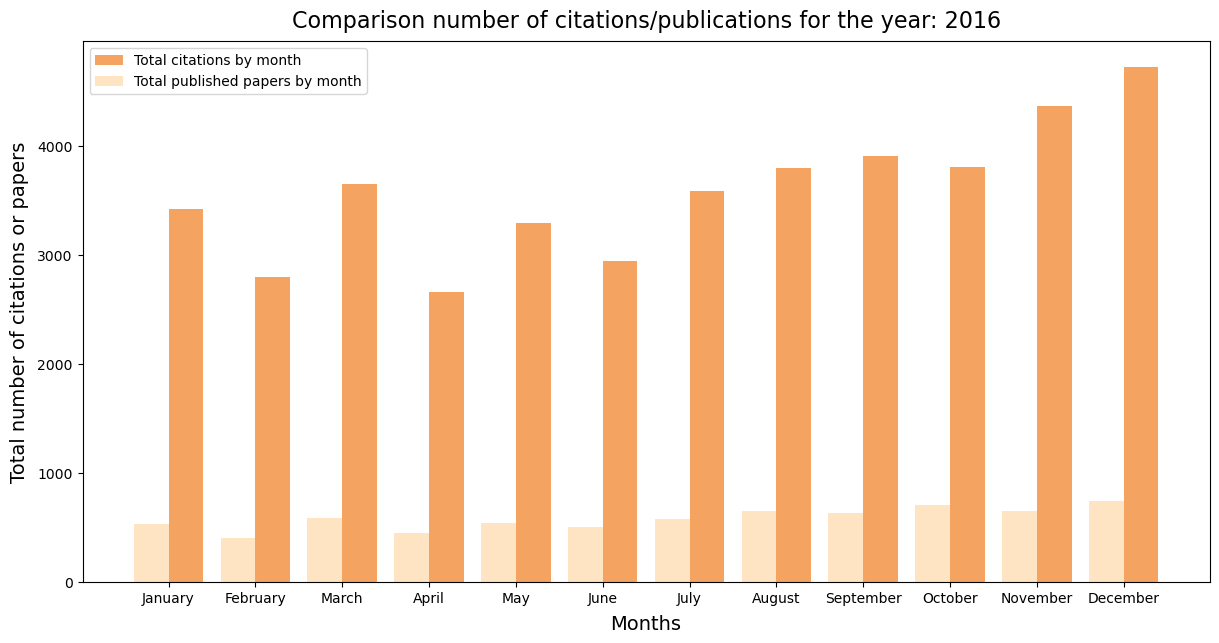

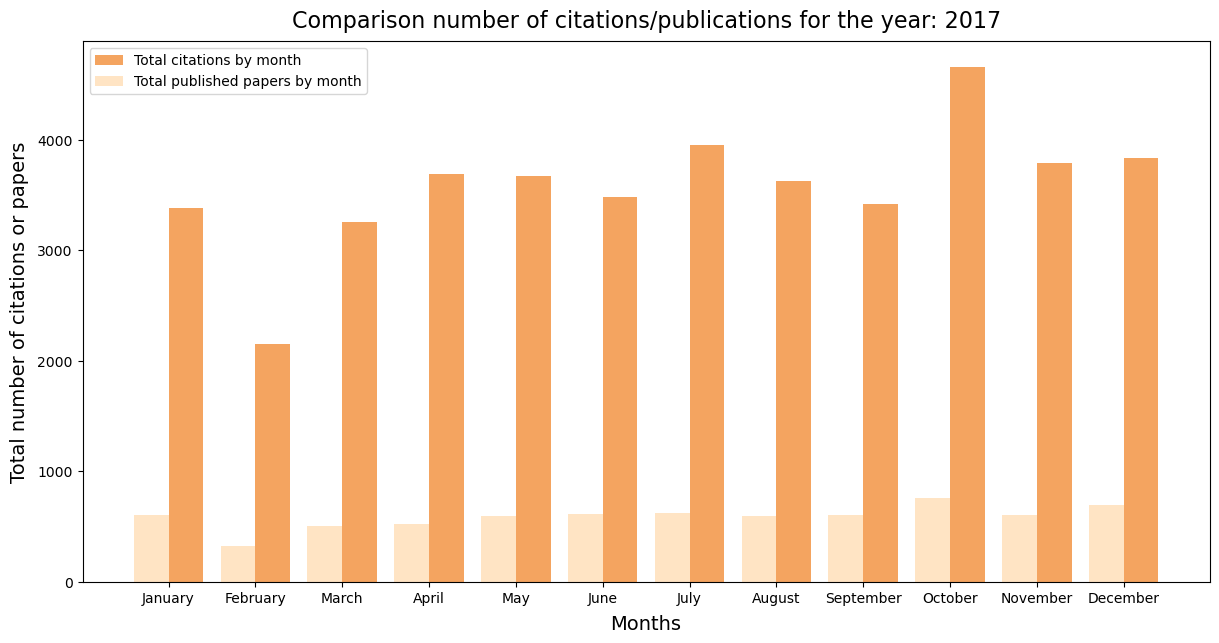

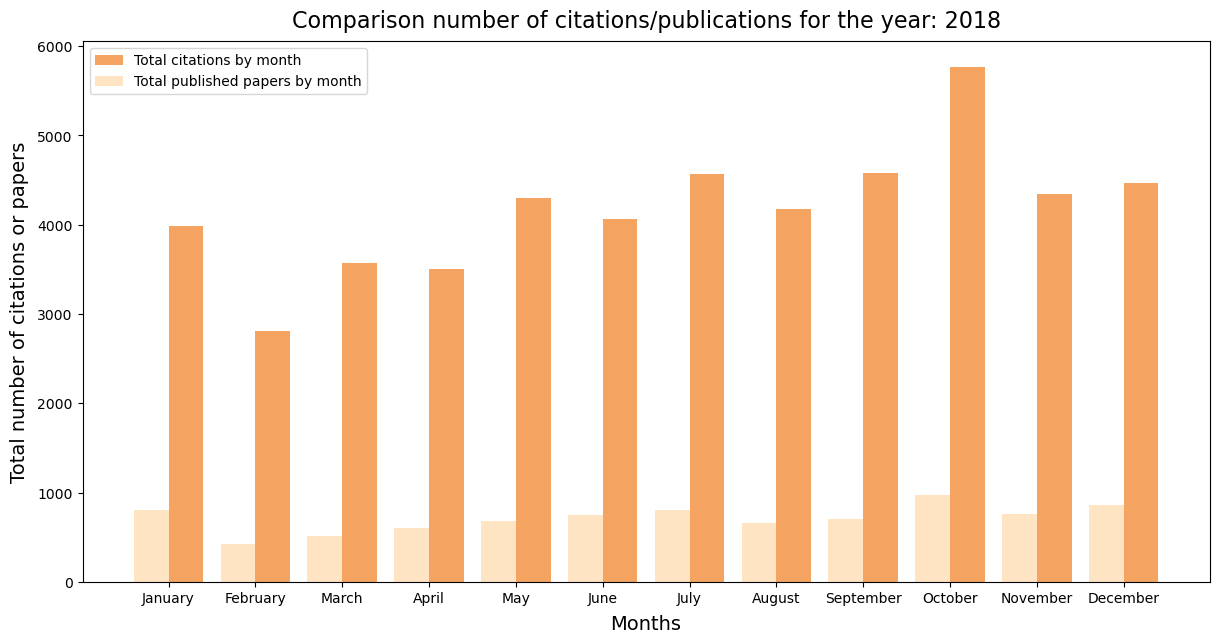

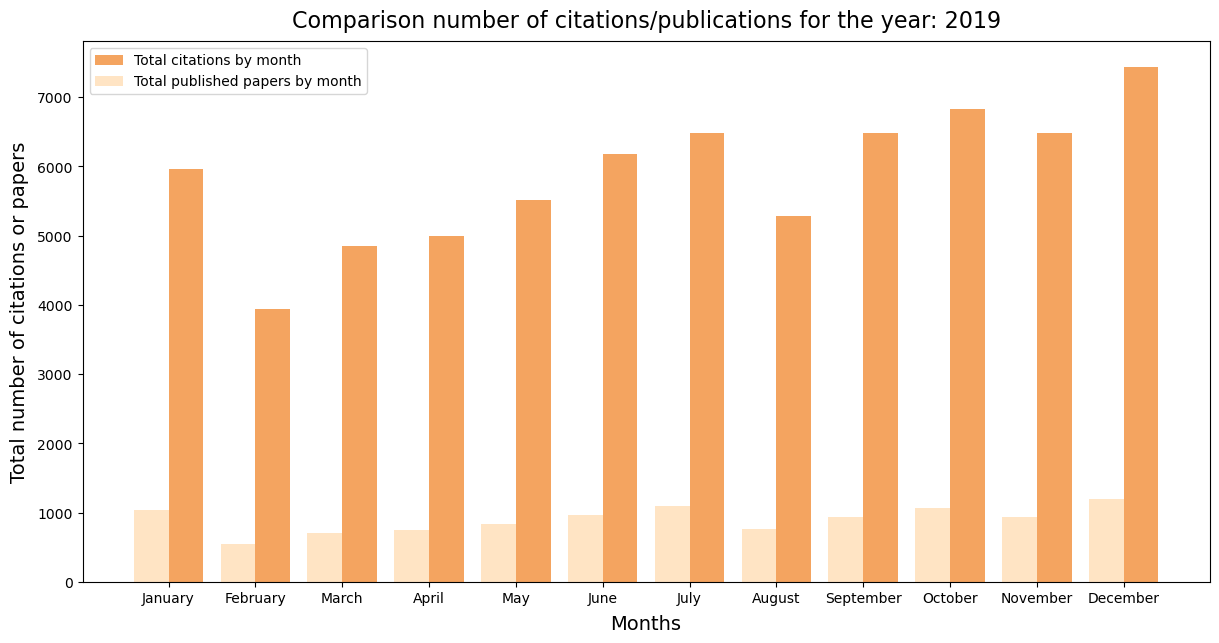

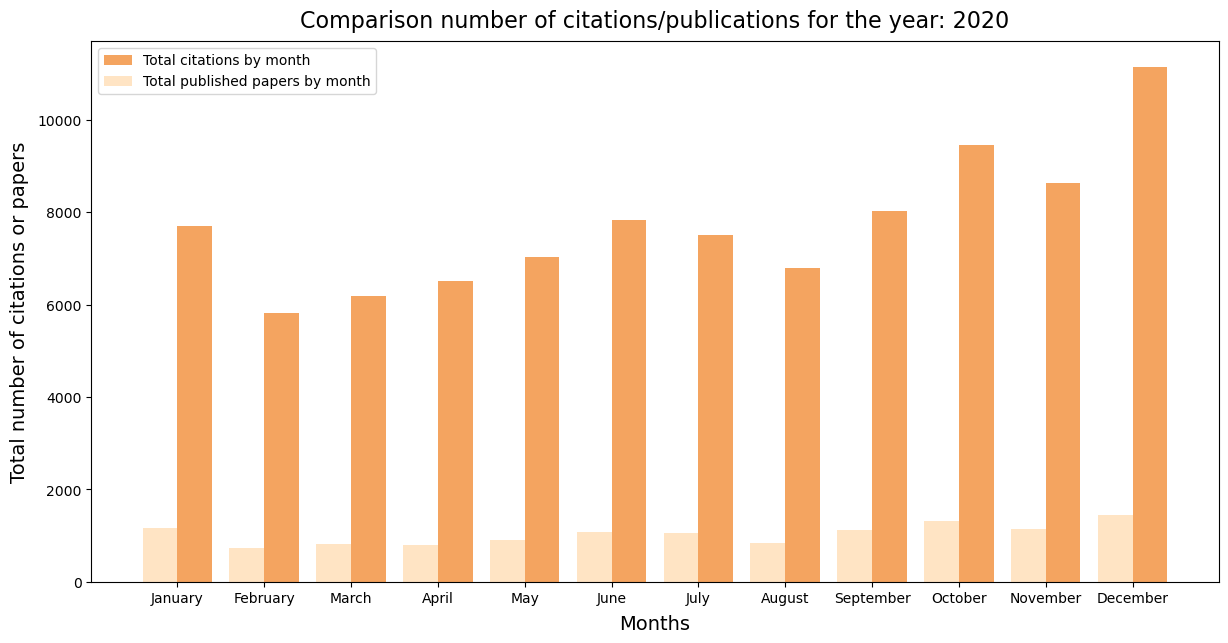

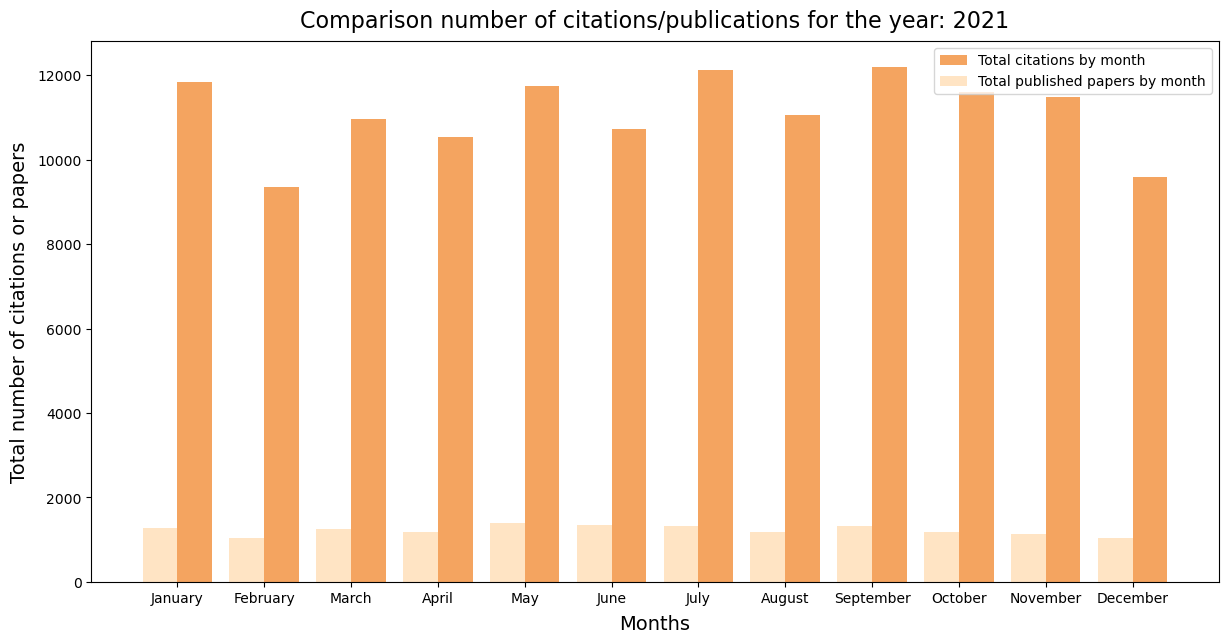

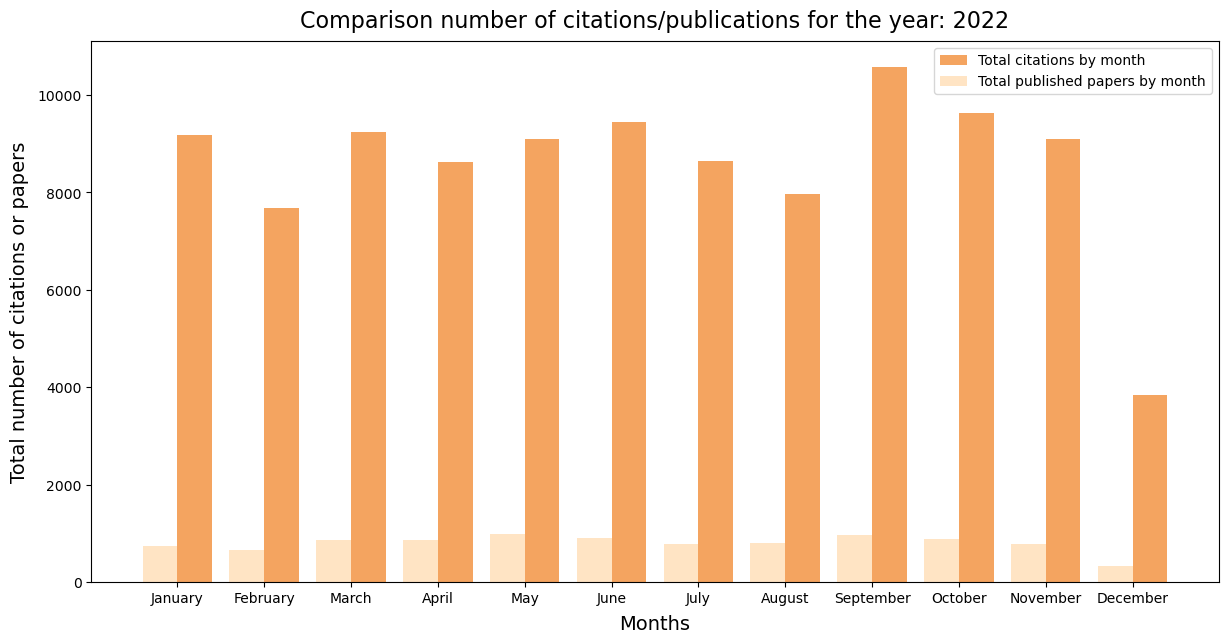

In [35]:
label_specs = {"fontsize": 14,"labelpad":6}
title_specs = {"fontsize": 16, "y": 1.01}

my_years = [2002,2003,2004,2005,2006,2007,2008,2009,2010,2011,2012,2013,2014,2015,2016,2017,2018,2019,2020,2021,2022]

my_months = ['January','February','March','April','May','June','July','August','September','October','November','December']

for year in my_years:
    #selecting the rows for a specific year
    infosyear = dfcitations.loc[dfcitations['year'] == year].copy() 
    infosyear_papers = df_time.loc[df_time['year'] == year].copy() 
    
    #creating lists counting the global number of citations and publications by month (for a specific year)
    total_cit_bymonth = []
    numberpapers_published_bymonth=[]
    for month in my_months:
        # we take the overall number of citations
        infosmonth = infosyear.loc[infosyear['month'] == month].copy() 
        myinfocit = infosmonth.citforthemonth.tolist() 
        total_cit_bymonth.append(sum(myinfocit))
        
        # we take the number of published papers for the month
        infosmonth_papers = infosyear_papers.loc[infosyear_papers['month'] == month].copy() 
        numberpapers_published_bymonth.append(len(infosmonth_papers))
    
    width = 0.4 
    first_bar_label = 'Total citations by month'
    first_bar_color = 'sandybrown'
    second_bar_label = 'Total published papers by month'
    second_bar_color = 'bisque'
    
    fig, ax = plt.subplots(figsize=(12,6))
    plt.tight_layout()
    
    # score bar chat
    # setting the axes of our horizontal bar plot
    x_cor = np.arange(0,12,1)
    ax.bar(x_cor + width/2, total_cit_bymonth, width, label=first_bar_label, color=first_bar_color)
    ax.bar(x_cor - width/2, numberpapers_published_bymonth, width, label=second_bar_label, color=second_bar_color) 
    # setting the column of our dataset ('number of papers') that we want to plot as a numerical variable

    ax.legend()
    
    # setting the labels of our axes
    plt.xlabel("Months",**label_specs)
    plt.ylabel("Total number of citations or papers",**label_specs)
    
    plt.xticks(x_cor, my_months)

    # setting the bar plot title
    plt.title("Comparison number of citations/publications for the year: "+str(year),**title_specs)

    # showing the bar plot (command not necessary, but it avoids to print the explanation text)
    plt.show()

__Observations__

At the beginning there are a lot of publications and almost no citations. This is normal, since we consider the referenced works that are themselves works within the field of encryption technologies published within the period 2002-2022. Therefore, the papers that were published in 2002, cited a lot of other papers from past years, that are not considered here. This is something we should maybe keep in mind: citations analysis will make more sense from the years 2004-2005 to 2022 than directly at the beginning.

<div class="alert-info">
7. Correlation analysis
</div>

In [36]:
infile_finaldicocitation_full = open('../creation_data_and_variables/data_creation_variables/finaldicocitation','rb')
dfcitations = pickle.load(infile_finaldicocitation_full)
infile_finaldicocitation_full.close()

In [37]:
infile_dfcitbasic_full = open('../creation_data_and_variables/data_creation_variables/dfcitbasic','rb')
dfcitbasic = pickle.load(infile_dfcitbasic_full)
infile_dfcitbasic_full.close()

In [38]:
dfcitbasic

citing_paper                       cited_paper  \
0       https://openalex.org/W2885223756   https://openalex.org/W893234787   
1       https://openalex.org/W2885223756  https://openalex.org/W1559136758   
2       https://openalex.org/W2885223756  https://openalex.org/W2290426788   
3       https://openalex.org/W2885223756  https://openalex.org/W3021222613   
4       https://openalex.org/W2755079943  https://openalex.org/W1993203618   
...                                  ...                               ...   
986870  https://openalex.org/W2794757751  https://openalex.org/W1279320161   
986871  https://openalex.org/W2794757751  https://openalex.org/W2487288527   
986872  https://openalex.org/W2794757751  https://openalex.org/W2504579840   
986873  https://openalex.org/W4214588288  https://openalex.org/W1944092705   
986874  https://openalex.org/W4214588288  https://openalex.org/W2055603434   

       publication_date     month  year  
0            2018-08-16    August  2018  
1            2018-08-16    August  2018  
2            2018-08-16    August  2018  
3            2018-08-16    August  2018  
4            2017-10-01   October  2017  
...                 ...       ...   ...  
986870       2017-11-01  November  2017  
986871       2017-11-01  November  2017  
986872       2017-11-01  November  2017  
986873       2021-10-01   October  2021  
986874       2021-10-01   October  2021  

[986875 rows x 5 columns]

Sadly, since there are no numerical or categorical data in the dataset "dfcitbasic", we can not visualize this dataset with a heat map or with a pairplot.

Nevertheless, we can consider the dataset below, which has more numerical value.

In [39]:
dfcitations

paper  year      month  \
0         https://openalex.org/W2885223756  2002    January   
1         https://openalex.org/W2885223756  2002   February   
2         https://openalex.org/W2885223756  2002      March   
3         https://openalex.org/W2885223756  2002      April   
4         https://openalex.org/W2885223756  2002        May   
...                                    ...   ...        ...   
34132891  https://openalex.org/W4214588288  2022     August   
34132892  https://openalex.org/W4214588288  2022  September   
34132893  https://openalex.org/W4214588288  2022    October   
34132894  https://openalex.org/W4214588288  2022   November   
34132895  https://openalex.org/W4214588288  2022   December   

          cituptothistime_year  cituptothistime_month  citforthemonth  \
0                            0                      0               0   
1                            0                      0               0   
2                            0                      0               0   
3                            0                      0               0   
4                            0                      0               0   
...                        ...                    ...             ...   
34132891                     0                      0               0   
34132892                     0                      0               0   
34132893                     0                      0               0   
34132894                     0                      0               0   
34132895                     0                      0               0   

          citfortheyear  
0                     0  
1                     0  
2                     0  
3                     0  
4                     0  
...                 ...  
34132891              0  
34132892              0  
34132893              0  
34132894              0  
34132895              0  

[34132896 rows x 7 columns]

In [40]:
from pandas.api.types import CategoricalDtype

my_months = ['January','February','March','April','May','June','July','August','September','October','November','December']

cat_dtype = CategoricalDtype(
    categories=my_months, ordered=True)
dfcitations['month']=dfcitations['month'].astype(cat_dtype)

In [41]:
dfcitations['year']=dfcitations['year'].astype(int)

In [42]:
dfcitations.dtypes

paper                      object
year                        int32
month                    category
cituptothistime_year        int64
cituptothistime_month       int64
citforthemonth              int64
citfortheyear               int64
dtype: object

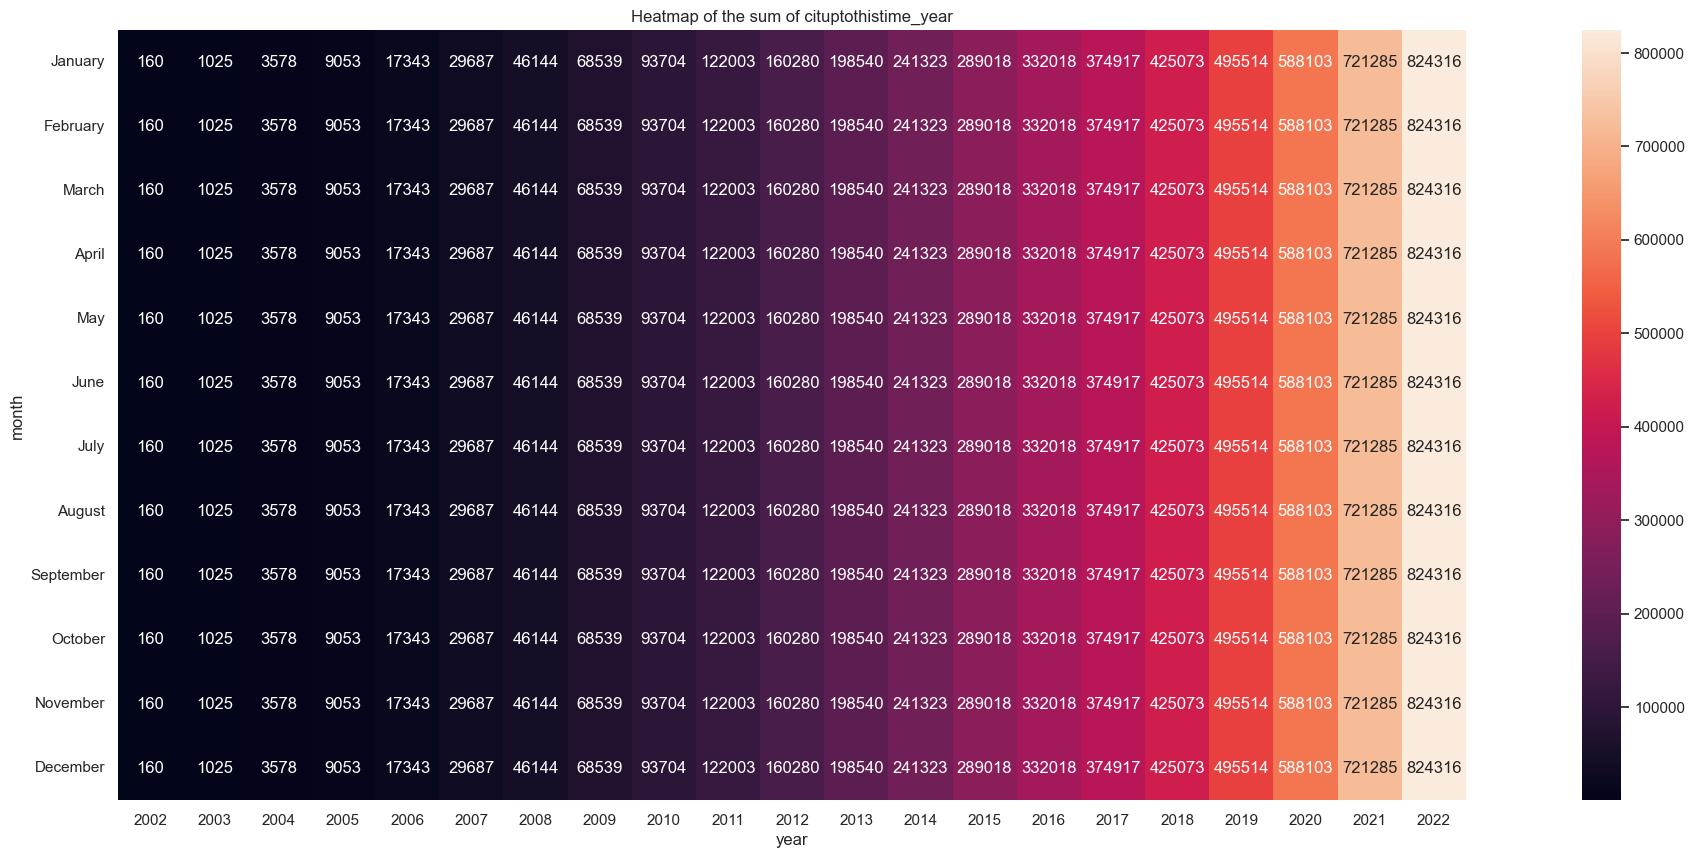

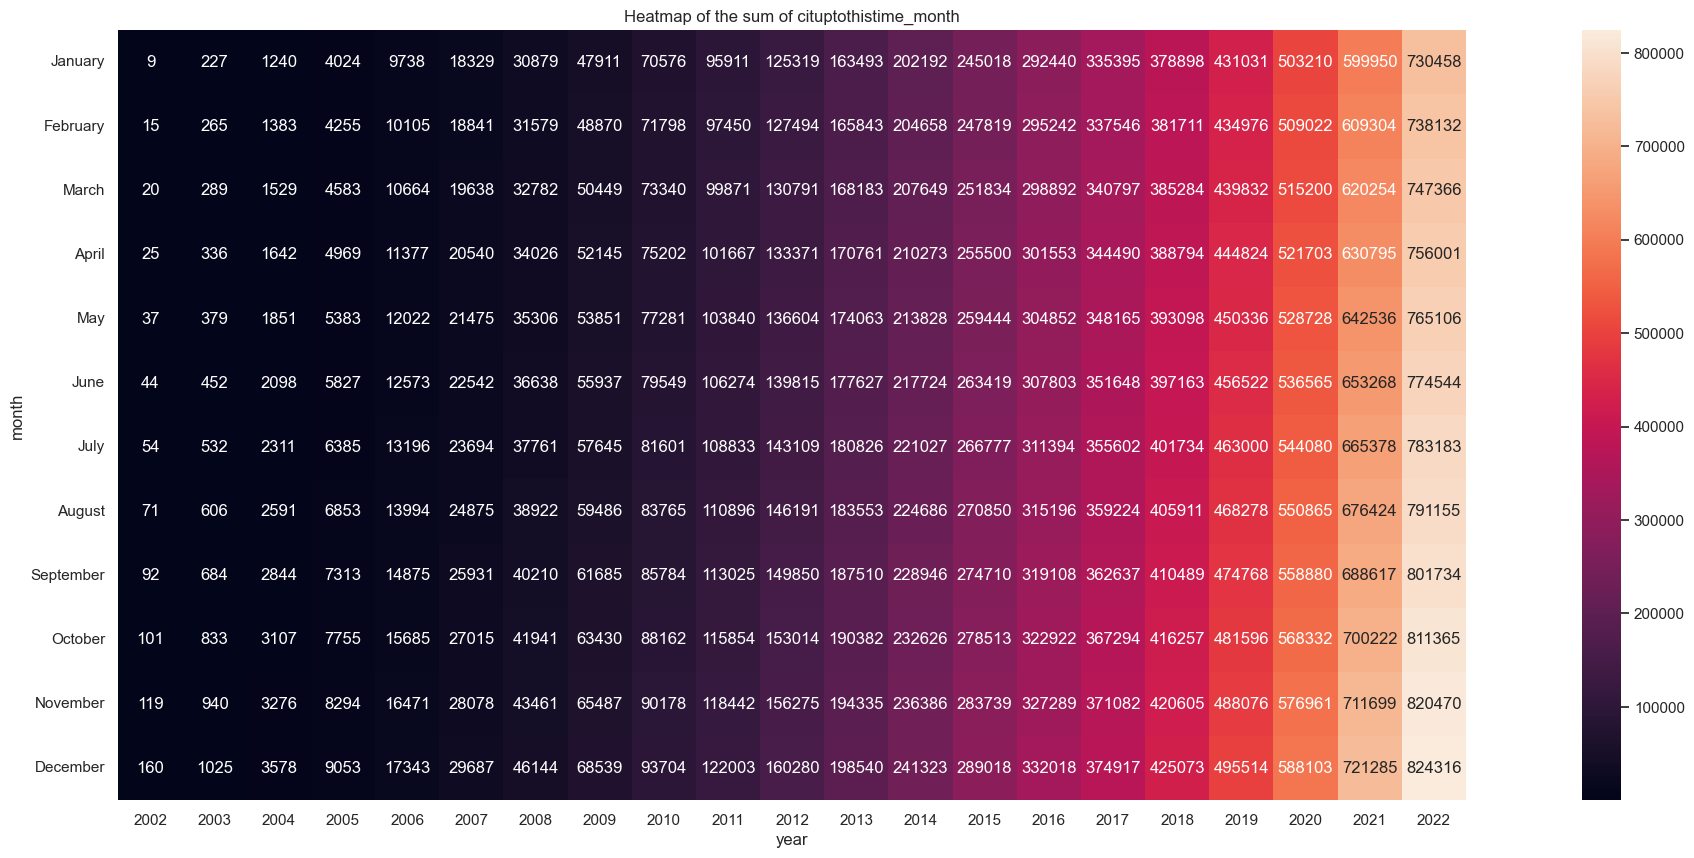

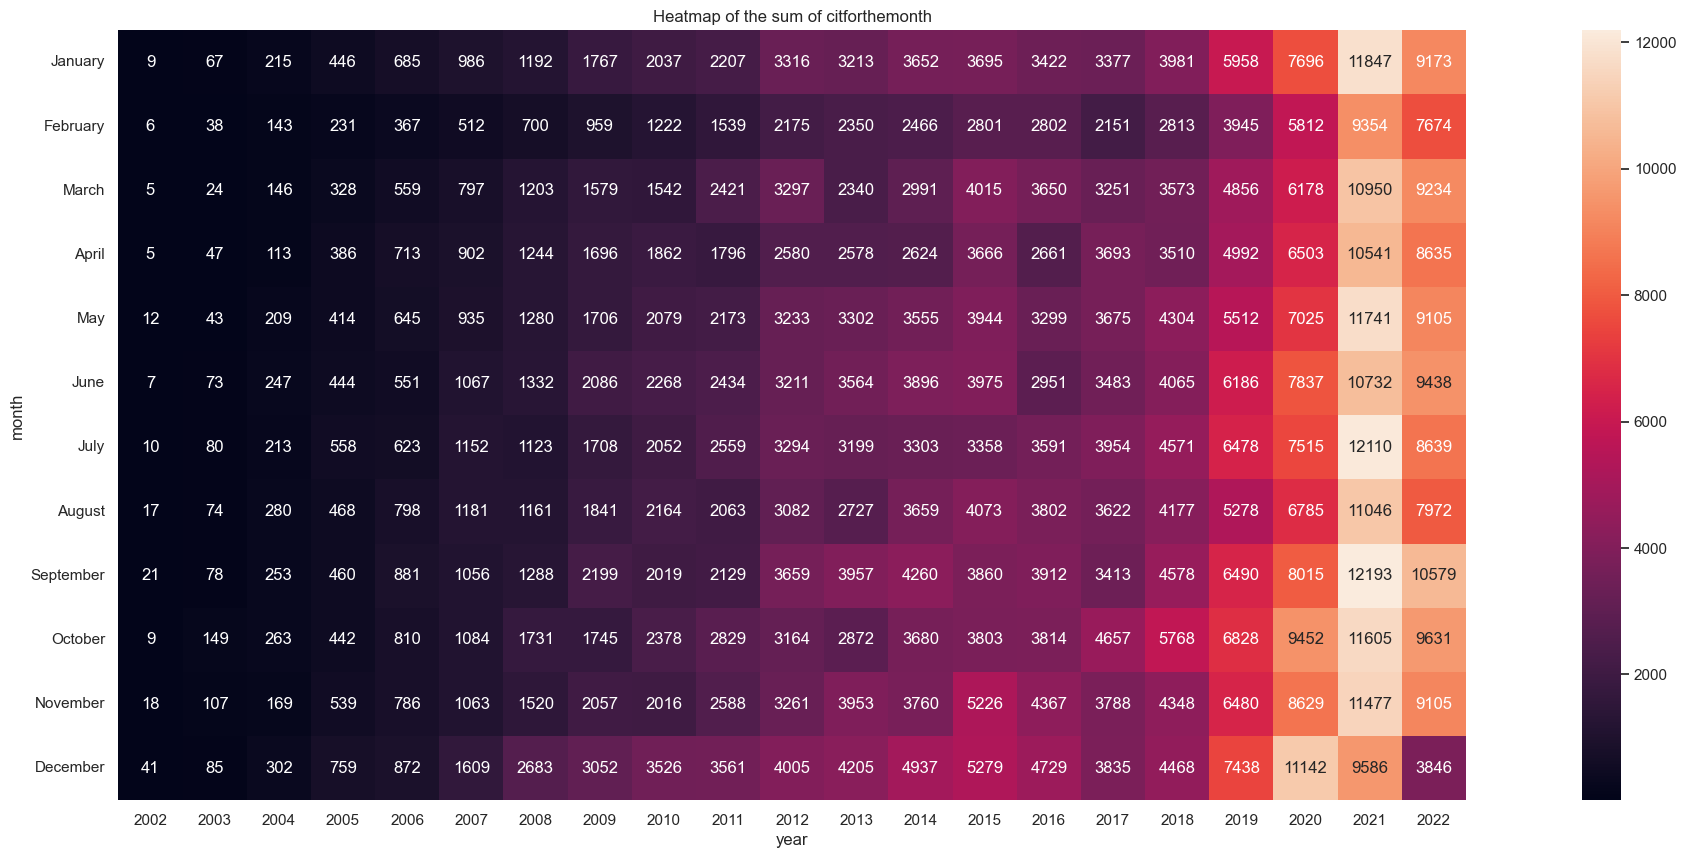

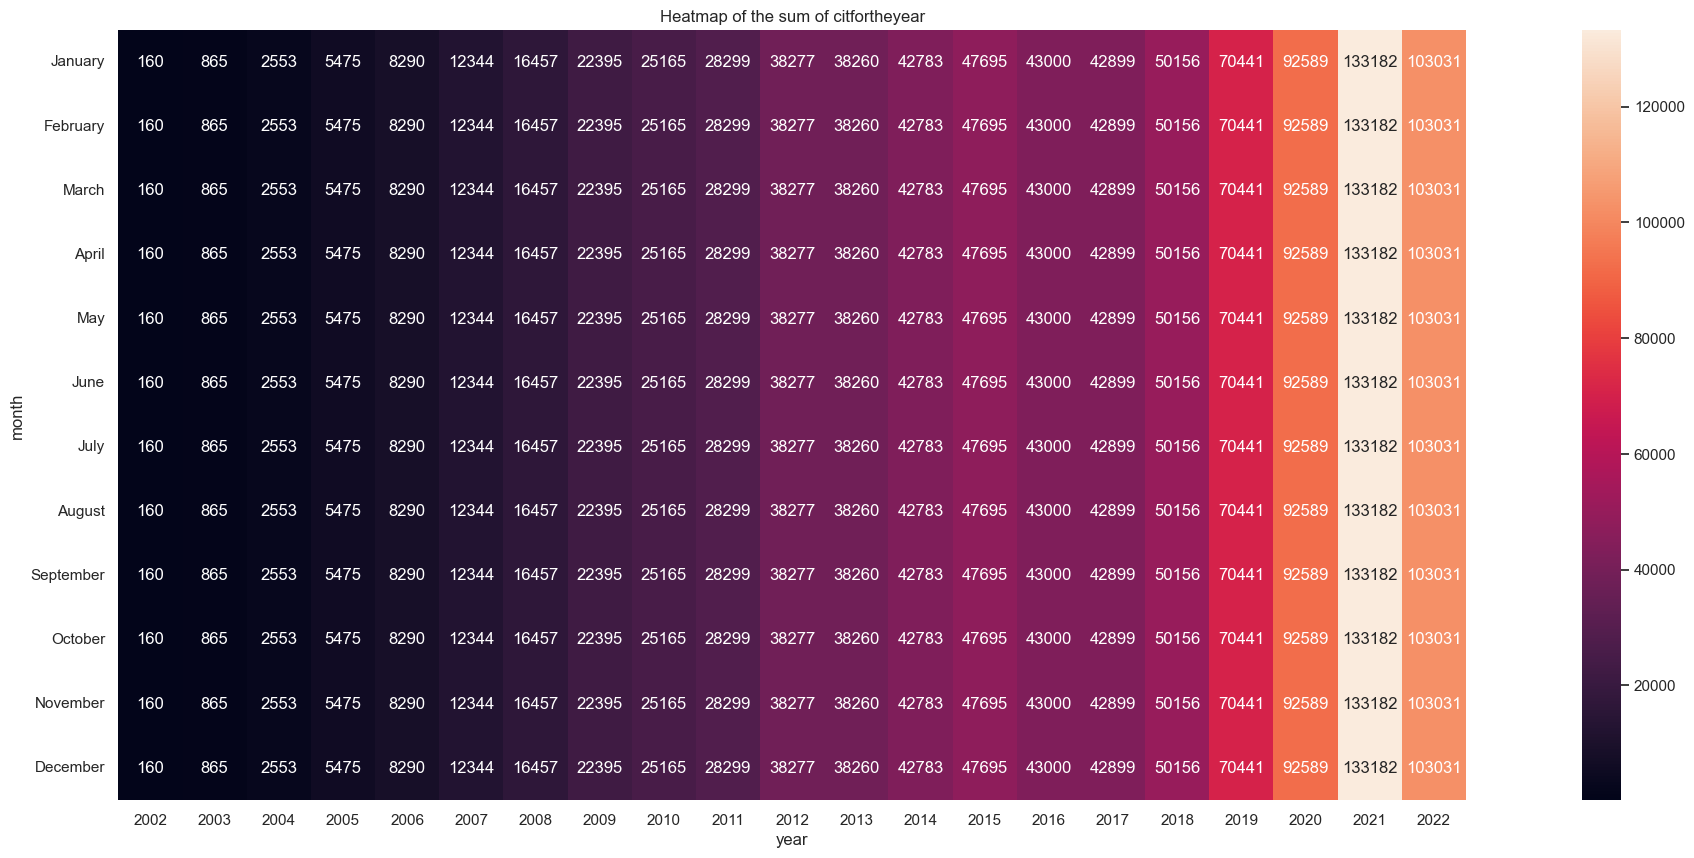

In [43]:
for column in ['cituptothistime_year','cituptothistime_month','citforthemonth','citfortheyear']:
    heatmap_data = pd.pivot_table(
    dfcitations
        , values=column, index="month", columns="year", aggfunc=np.sum
    )

    sns.set(rc={"figure.figsize": (30, 10)})
    sns.heatmap(heatmap_data, annot=True, square=True, fmt=".0f").set(
    title="Heatmap of the sum of "+str(column)
    )
    plt.show()

__Observations__

We see that the number of citations by year, and also for each year and for each month increases with time. This is due to the increase of interconnectivity within our network of papers.

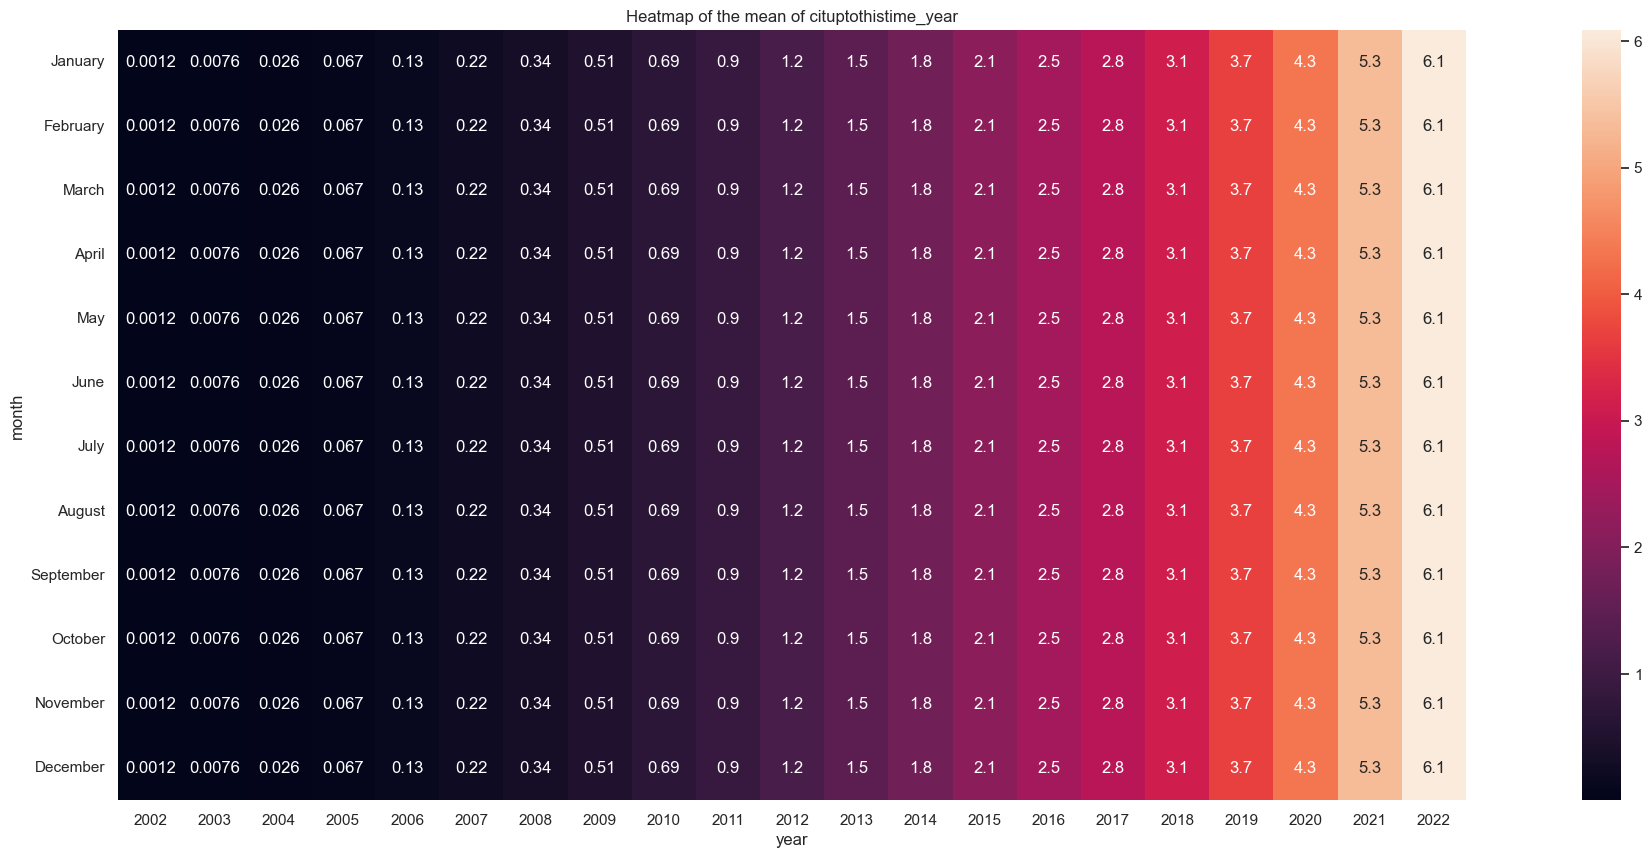

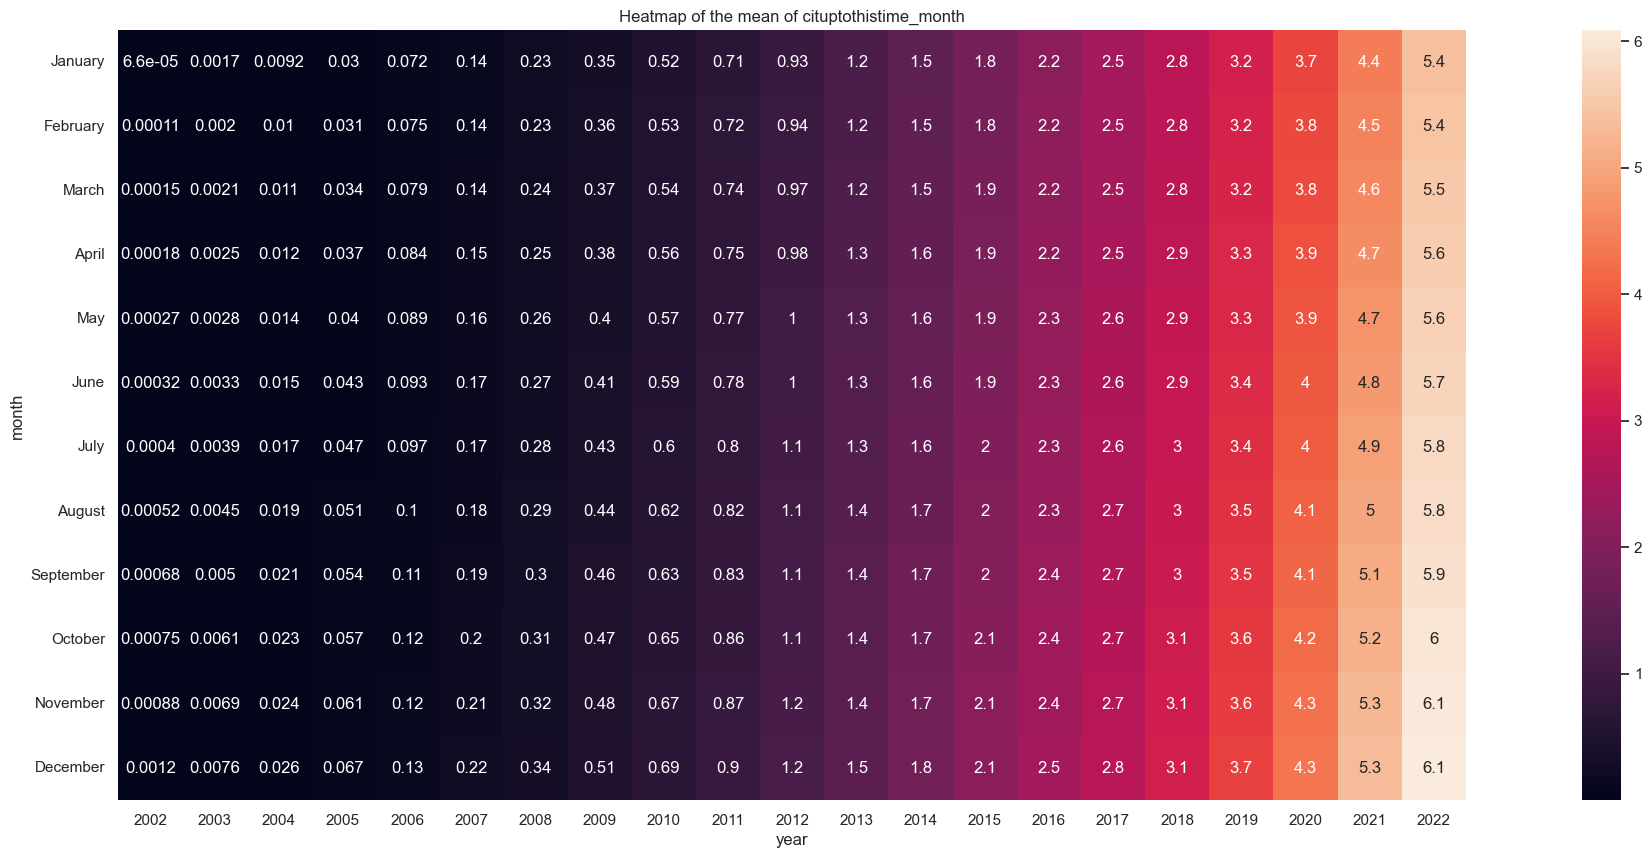

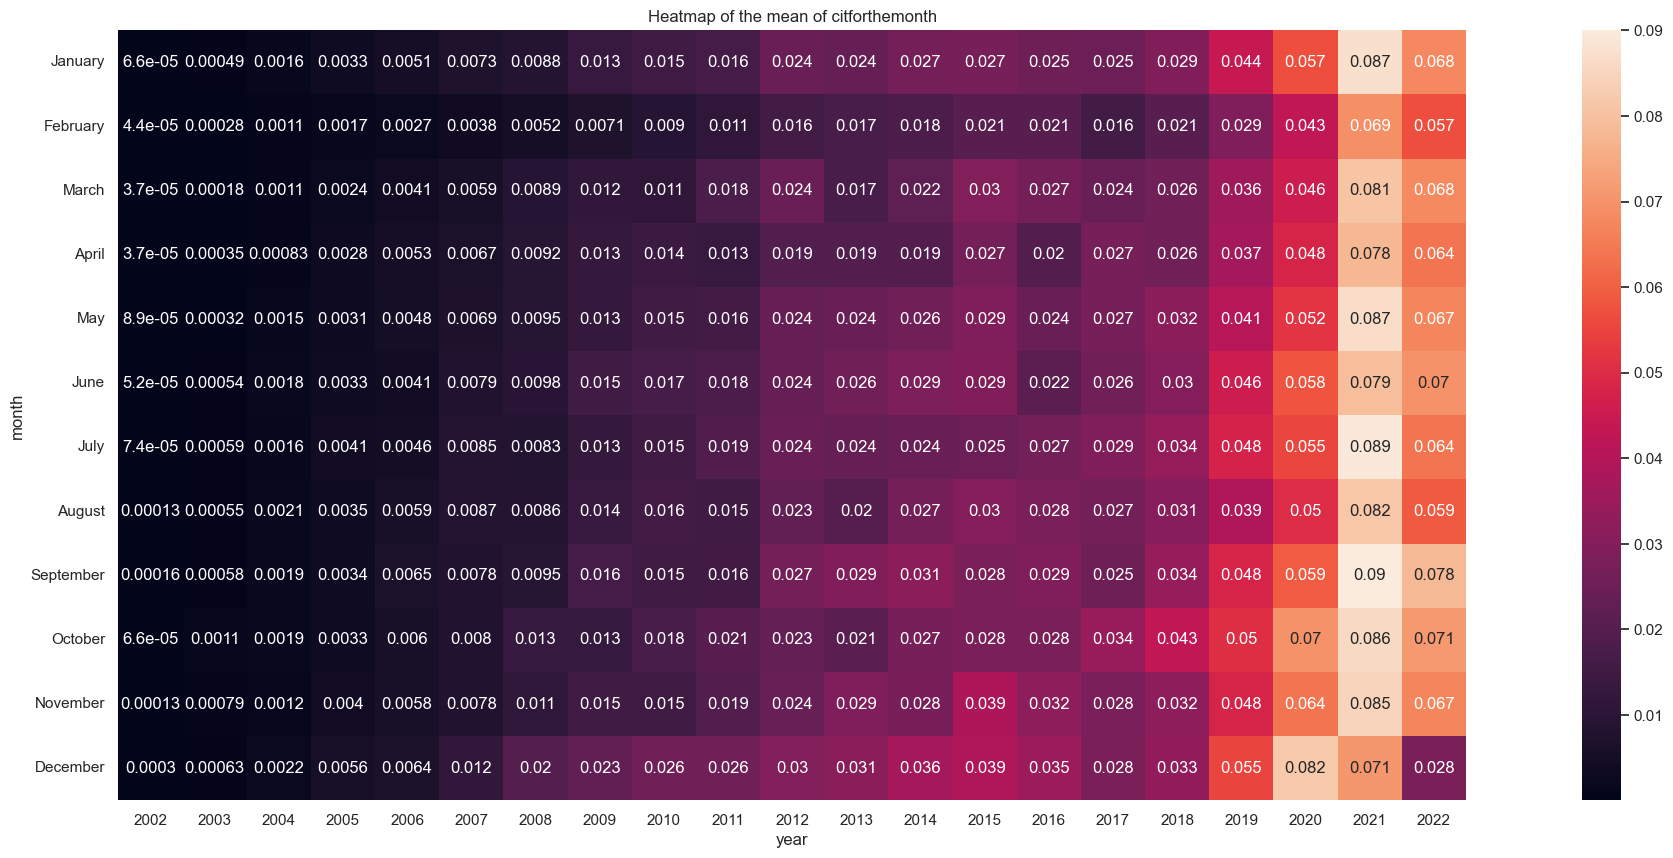

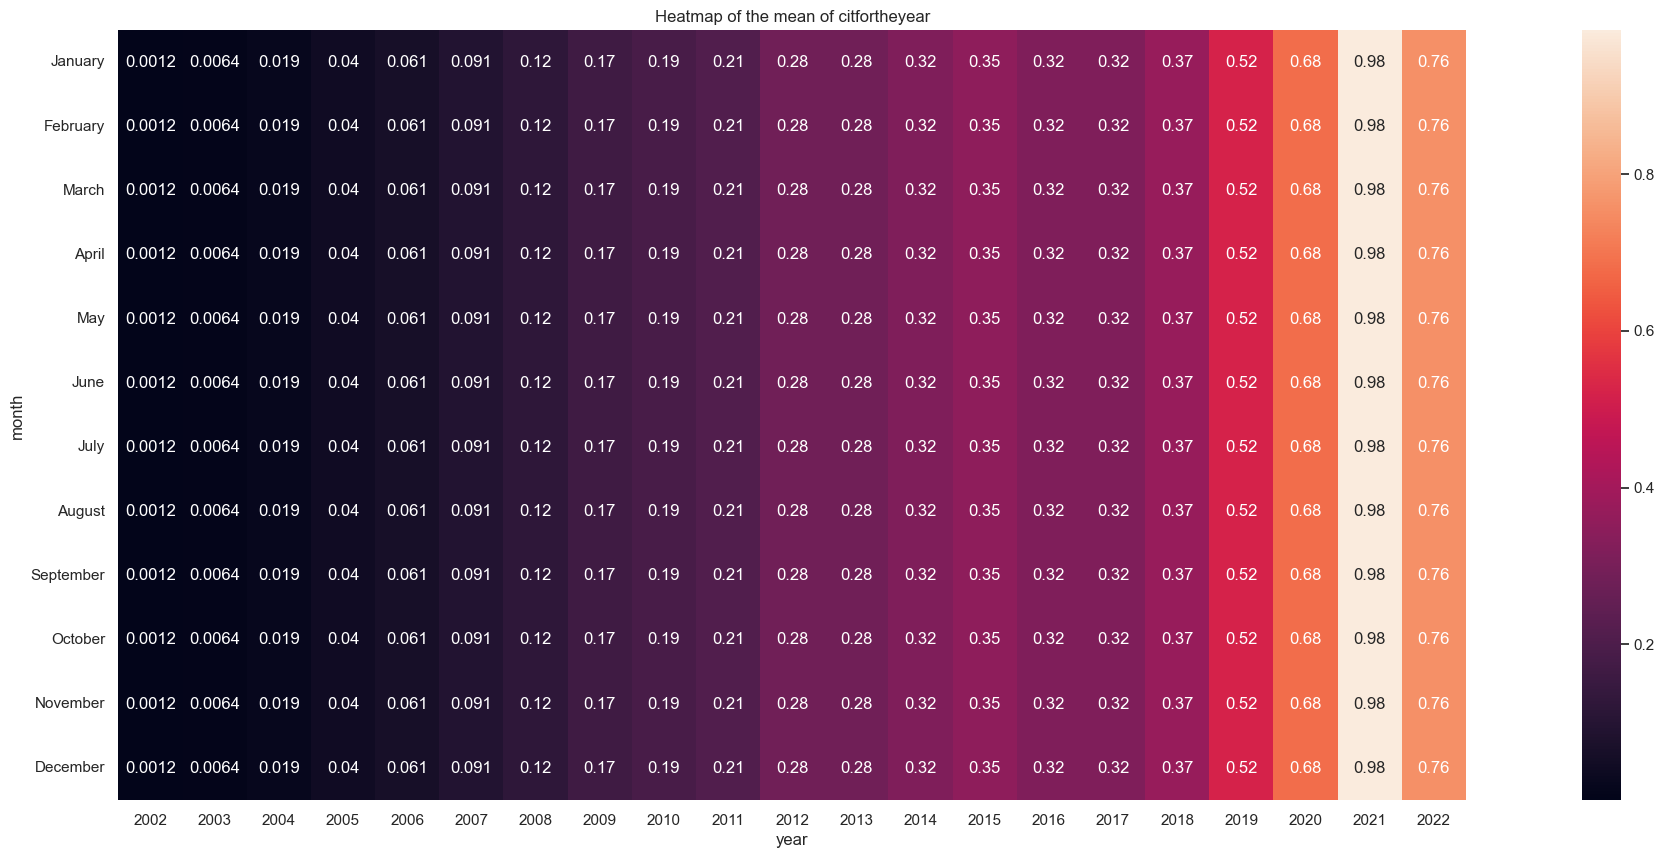

In [44]:
for column in ['cituptothistime_year','cituptothistime_month','citforthemonth','citfortheyear']:
    heatmap_data = pd.pivot_table(
    dfcitations, values=column, index="month", columns="year", aggfunc=np.mean
    )

    sns.set(rc={"figure.figsize": (30, 10)})
    sns.heatmap(heatmap_data, annot=True, square=True).set(
    title="Heatmap of the mean of "+str(column)
    )
    plt.show()

__Observations__

We see that the mean of citations by year, and also for each year and for each month for each paper increases with time. This is due to the increase of interconnectivity within our network of papers.

Last, but not least, we visualize the correlation of our data, to see how it is distributed.

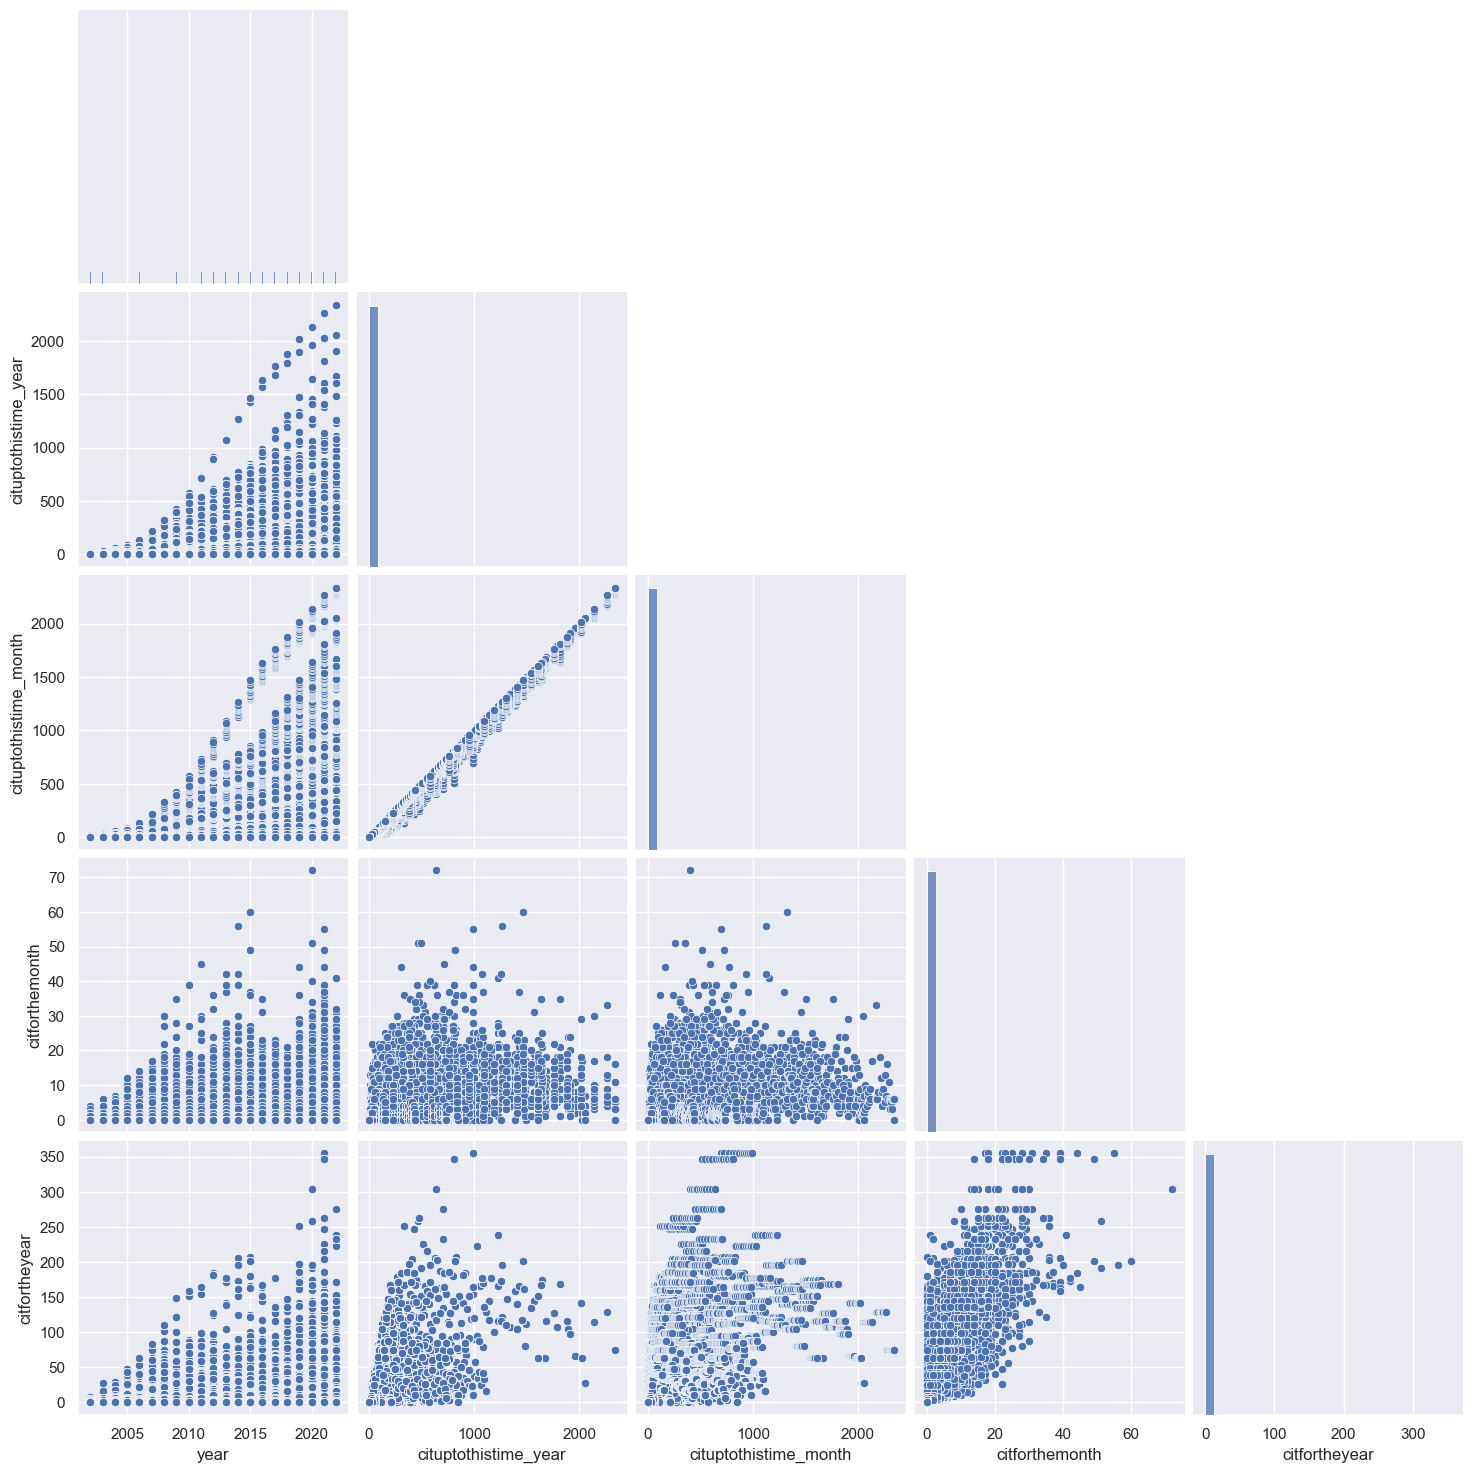

In [45]:
sns.pairplot(dfcitations, height=3,corner=True)
plt.show()

__Observations__

Clearly, the citations up to this month and the citations up to this year are very correlated. Most of the citations variables are zero that is why we only see a big bar chart at zero for all our variables. As planned, there is an increase of citations over the years in all the categories of citations (to this year, for the year, for the month).
The rest of the correlation is pretty much as expected. For example for the correlation citations for the month and citations up to this year, most the citations for the month are low, while it takes all the axis for the citations up to this year. One must keep in mind that the y-axis are very different and create a visual bias.

In [46]:
dfcitations.corr()

year  cituptothistime_year  cituptothistime_month  \
year                   1.000000              0.118963               0.117037   
cituptothistime_year   0.118963              1.000000               0.997036   
cituptothistime_month  0.117037              0.997036               1.000000   
citforthemonth         0.076634              0.514210               0.488168   
citfortheyear          0.103137              0.692044               0.649686   

                       citforthemonth  citfortheyear  
year                         0.076634       0.103137  
cituptothistime_year         0.514210       0.692044  
cituptothistime_month        0.488168       0.649686  
citforthemonth               1.000000       0.743031  
citfortheyear                0.743031       1.000000

In [47]:
corr_df = pd.DataFrame(np.tril(dfcitations.corr()))

In [48]:
corr_df_lowtriangular = corr_df.where(np.tril(np.ones(corr_df.shape)).astype(bool))

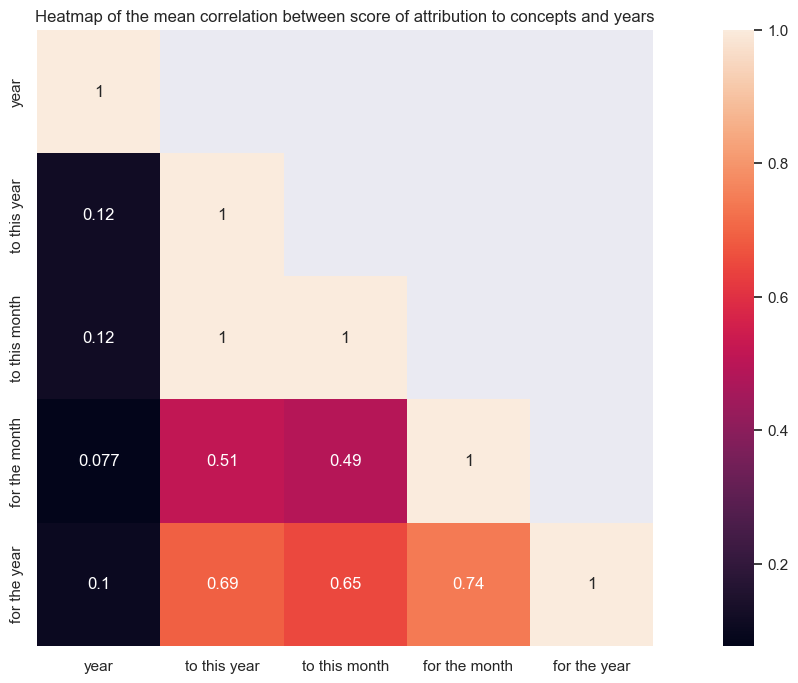

In [49]:
sns.set(rc={"figure.figsize": (18, 8)})
sns.heatmap(corr_df_lowtriangular, annot=True, square=True).set(
title="Heatmap of the mean correlation between score of attribution to concepts and years",
xticklabels=['year','to this year','to this month','for the month','for the year'],
yticklabels=['year','to this year','to this month','for the month','for the year']
)
plt.show()

__Observation__

We can see, that as expected the variable ```year``` is not correlated with different count of citations. The citations up to this month are highly correlated with citations up to this year as expected. The citation for the month are a bit correlated to citations up to this year and to citations up to this month, which is a bit suprising. This is because it is often zero. Citations for the year are very correlated to citations up to this month and up to this year and slightly correlated to citations for the month. This probably due to the high concentration of zeroes everywhere.